# <center> - Pump it Up: Data Mining the Water Table -
## <center>David Jesús Peña Muñoz

Competencia DRIVENDATA

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

Can you predict which water pumps are faulty to promote access to clean, potable water across Tanzania? This is an intermediate-level practice competition. Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


Se nos proporciona el siguiente conjunto de información sobre los puntos de agua:

- ***amount_tsh*** *- Total static head (amount water available to waterpoint)*
- ***date_recorded*** *- The date the row was entered*
- ***funder*** *- Who funded the well*
- ***gps_height***  Altitude of the well
- ***installer*** *- Organization that installed the well*
- ***longitude*** *- GPS coordinate*
- ***latitude*** *- GPS coordinate*
- ***wpt_name*** *- Name of the waterpoint if there is one*
- **num_private**
- ***basin*** - Geographic water basin
- ***subvillage*** - Geographic location
- ***region*** - Geographic location
- ***region_code*** - Geographic location (coded)
- ***district_code*** - Geographic location (coded)
- ***lga*** - Geographic location
- ***ward*** - Geographic location
- ***population*** - Population around the well
- ***public_meeting*** - True/False
- ***recorded_by*** - Group entering this row of data
- ***scheme_management*** - Who operates the waterpoint
- ***scheme_name*** - Who operates the waterpoint
- ***permit*** - If the waterpoint is permitted
- ***construction_year*** - Year the waterpoint was constructed
- ***extraction_type*** - The kind of extraction the waterpoint uses
- ***extraction_type_group*** - The kind of extraction the waterpoint uses
- ***extraction_type_class*** - The kind of extraction the waterpoint uses
- ***management*** - How the waterpoint is managed
- ***management_group*** - How the waterpoint is managed
- ***payment*** - What the water costs
- ***payment_type*** - What the water costs
- ***water_quality*** - The quality of the water
- ***quality_group*** - The quality of the water
- ***quantity*** - The quantity of water
- ***quantity_group*** - The quantity of water
- ***source*** - The source of the water
- ***source_type*** - The source of the water
- ***source_class*** - The source of the water
- ***waterpoint_type*** - The kind of waterpoint
- ***waterpoint_type_group*** - The kind of waterpointpe_group - The kind of waterpoint 

## NOTAS DE VERSIONES

In [1]:
# Version 0.1 - Version Base - Score: 0.8148
# - Se corrigen los datos con NA, se imputan nuevos valores 'Unknown'.
# - No hay ningun tratamiento especial a la data en cuanto a creación de nuevas variables.
# - No se elimina ninguna variable del modelo.
# - Se usa labelencoder para transformar var. categóricas a numéricas
# - Se decide que el modelo más optimo es un Random Forest

#Version 1.1 - Score: 0.8120
# - Uso de oversampling al 100% para crear datos sintéticos.

#Version 1.2 - Score: 0.8139
# - Uso de oversampling al 40% para crear datos sintéticos.
#Score - Validacion cruzada
# Modelo: RandomForestClassifier
#Puntajes de validación cruzada: [0.80702862 0.80713384 0.80734428 0.8047138  0.80618687]
#Promedio de puntajes: 0.8064814814814815
#Desviación estándar de los puntajes: 0.0009675558865801695
###########################################################

#Version 2.0 - Score: 0.8139
# - Se aplica tuneo de hyperparámetros con un GridSearchCV

#Version 2.1 - Score: 0.8153
# - Se aplica tuneo de hyperparámetros, con class_weight={1: 1, 2: 1, 3: 3}.

#Version 2.2 - Score: 0.8161
# - Imputaciones basicas de NA por Uknown
# - No tengo en cuenta la variable date_recorded
# - Cabiamos el porcentaje de trainint y test a 85/15, cogiendo el modelo del RF con el parametro class_weight. 
# - El modelo resultante es el model2_w3_15

#Version 3 - Score: 0.7839
# - Intento aplicar XGBOOST y de nuevo un diccionario de hyperparámetros con el GridSearchCV

#Version 4 - model2_w2_20 - Score: 0.8145
# - Me centro en la imputacion de variables.
# - Agrupo categorias extrañas de que presentan una sola letra.
# - En variabels dicotómicas, no genero una nueva categoría Unknown sino que imputo segun el % de la distribución.
# - Borro la variable recorded _by, al tener un solo valor no aporta nada al modelo.

#Version 4.1 - model2_w4_30 - Score: 0.8100
# - No hago imputaciones de variables cuando la categoria tiene 1 caracter.
# - En variables dicotomicas asigno por Moda.
# - scheme management - En este caso aglutino las categorias de Other con SWC y Trust
# - Borro la variable recorded_by
# - Borro la variable recorded_date
# - El mejor modelo es: model2_w4_30, con un promedio de puntajes de: 0.8082281144781145

#Version 4.2. -
# - Agrupo categorias extrañas de que presentan una sola letra.
# - permit imputo %.
# - public_meeting imputo por %.
# - Convierto categoria '0' en funder y installer a Unknown

#version 5-
# - Limpieza de toda la estructura
# - Gestion de outlayers.

In [2]:
# Import de librerias y funciones
import pandas as pd
import numpy as np
import warnings

import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

#Label Encoder
from sklearn.preprocessing import LabelEncoder

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.calibration import CalibratedClassifierCV

# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report
from sklearn import metrics

#Oversampling
from imblearn.over_sampling import SMOTE

In [3]:
### import de FUNCIONES

def plot_top_categories(data, variable, top):
    # Calcula el conteo de cada categoría para la variable
    conteo_variable = data[variable].value_counts()

    # Selecciona los top_n valores con mayor frecuencia
    top_variable = conteo_variable.head(top)

    # Obtén el valor máximo de frecuencia
    max_freq_variable = top_variable.max()

    # Grafica el conteo de los top_n valores con mayor frecuencia
    top_variable.plot(kind='bar')

    # Establece el límite del eje y al valor máximo
    plt.ylim(0, max_freq_variable)

    # Etiquetas y título
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    plt.title(f'Top {top} valores de {variable}')

    # Muestra la gráfica
    plt.show()

#Ejemplo de uso top=20
#plot_top_categories(data, 'installer', 20)  


#FUNCION PARA REALIZAR EL SPLIT DE LOS DATOS
def split_data(data, test_size):
    """
    Divide los datos en conjuntos de entrenamiento y prueba.

    Args:
    - data (DataFrame): El conjunto de datos.
    - test_size (float): El tamaño del conjunto de prueba (porcentaje).

    Returns:
    - Tuple: Retorna cuatro conjuntos de datos: X_train, X_test, y_train, y_test.
    """
    X_train, X_test, y_train, y_test = train_test_split(data.drop('status_group', axis=1), 
                                                        data['status_group'],
                                                        test_size=test_size,
                                                        random_state=0,
                                                        stratify=data['status_group'])
    return X_train, X_test, y_train, y_test

#Ejemplo de uso para dividir los datos con un tamaño de prueba del 30%
#X_train_30, X_test_30, y_train_30, y_test_30 = split_data(data, test_size=0.3)


# FUNCION PARA VISUALIZAR LA MATRIZ DE CORRELACIONES

def visualizar_correlaciones(data):
    # Calcula la matriz de correlación
    correlation_mat = data.corr()

    # Crea el mapa de calor
    sns.heatmap(correlation_mat, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de correlación')

    # Muestra el mapa de calor
    plt.show()

    # Ordena las correlaciones de forma descendente
    sorted_correlations = correlation_mat.unstack().sort_values(ascending=False)

    # Muestra el listado de correlaciones ordenadas
    print("Listado de las 20 primeras correlaciones ordenadas:")
    count = 0
    for (variable1, variable2), correlacion in sorted_correlations.items():
        if variable1 != variable2:
            print(f"{variable1} - {variable2}: {correlacion:.2f}")
            count += 1
        if count >= 20:
            break

# <center>  PROYECT INDEX
-------------------------------------

# 1 - DATA ACQUISITION & UNDERSTANDING

Esta primera etapa del proyecto, implica los procesos de recopilar, impiar, explorar y comprender los datos que se utilizarán para entrenar y validar los modelos

## 1.1. Data upload

Desde la pagina web de la competencia: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/
se descargan los datos del proyecto, y se le asignan los siguientes nombres de archivo csv:

***- Test set values: testSetValues.csv***
<p> Variables independientes que necesitan predicciones.


***- Training set labels: trainingSetLabels.csv***
<p>La variable dependiente (status_group) para cada una de las filas en valores del conjunto de entrenamiento.

 
***- Training set values: trainingSetValues.csv***
<p>Las variables independientes para el conjunto de entrenamiento.ts

In [4]:
## Carga de datasets

training_values = pd.read_csv("data/trainingSetValues.csv", sep = ",")
training_labels = pd.read_csv("data/trainingSetLabels.csv", sep = ",")
test_values = pd.read_csv("data/testSetValues.csv", sep = ",")

Mostramos los datos cargados:

In [5]:
training_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [7]:
test_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


training_values y training_labels, conforman los registros con las variables y los valores de la variable objetivo status_group respectivamente de los datos que usaremos para training.
En test_values, estan los registros con la data (X_pred) cuya variable objetivo status_group tenemos que predecir (y_pred), y por lo tanto no tenemos  esos valores.

El objetivo de todo el proceso será partiendo desde estos datos de training, llegar a predecir los valores de la variable objetivo de los datos de test. 

## 1.2. Exploration & Understanding data

Procedemos a explorar y revisar toda la data que tenemos, para hacernos una idea de cual es la información que tenemos, cual es la naturaleza de los datos y ver las estrategias o decisiones que iremos tomando a lo largo del proceso. Es importante conocer que variables tienen datos NA y entender la naturaleza de su distribucion para poder decidir correctamente como se van a gestionar, si es recomendable realizarle alguna transformación ...

In [8]:
#Tamaño de tablas

print('Tamaño de tabla de trainig_values:',training_values.shape[0])
print('Tamaño de tabla de training_labels:',training_labels.shape[0])
print('Tamaño de tabla de test_values:',test_values.shape[0])

Tamaño de tabla de trainig_values: 59400
Tamaño de tabla de training_labels: 59400
Tamaño de tabla de test_values: 14850


El tamaño de trainig_values y training_labels es de 59400, es decir vamos a poder unirlos sin ningún problema.
Para poder unir ambas tablas, tiene que haber correspondencia entre los id de las 2 tablas de training. A su vez, vamos a comprobar si no existe correspondencia entre los id de training y test.

In [9]:
print('Puntos de agua en tablas de training\n', training_values['id'].isin(training_labels['id']).value_counts())
print('Correspondencia entre puntos de agua en tablas de training y test\n', training_values['id'].isin(test_values['id']).value_counts())
## Valores únicos training_values
print('Valores unicos de training_values: ',len(training_values['id'].unique()))
## Valores únicos training_labels
print('Valores unicos de training_labels: ',len(training_labels['id'].unique()))
## Valores únicos training_labels
print('Valores unicos de test_values: ',len(test_values['id'].unique()))

Puntos de agua en tablas de training
 id
True    59400
Name: count, dtype: int64
Correspondencia entre puntos de agua en tablas de training y test
 id
False    59400
Name: count, dtype: int64
Valores unicos de training_values:  59400
Valores unicos de training_labels:  59400
Valores unicos de test_values:  14850


Los datos de training y de test son correctos. Hay equivalencia en todos los id de los datos de training (values y labels) y no hay ninguna respecto a los id de test. Antes de proceder a explorar los datos, vamos a unir toda la data para conformar un sol odataset y poder opera sobre él.
En este punto podría tomar la decisión de tener 2 datasets distintos, uno con los datos de training (training_values y training_labels) y otro con los datos a predecir (test_values), pero en tal caso, se tendría que ir realizando todo el proceso de limpieza y preprocesado en paralelo, dando lugar a 2 procesos en paralelo, replicando código y aumentando la posibilidad de error. Por esto decido unir toda la data en un solo dataset, de forma que se tiene que separar los datos de training y test (X_pred en mi modelo final) antes de generar el modelo y aplicarlo. 
Al unirlo generaremos un dataset con registros que tendrán la variable objetivo como NA, estos registros son los que conforman los datos de test (X_pred).

In [10]:
#Union de datos de training y test en un solo dataset.

data_training = pd.merge(training_values, training_labels, on = "id", how = "left")

Creamos una variable con todas las id de los datos de test (X_pred), esta variable se llamará ids_test_values, así podremos realizar todo el procesado de los datos a el dataset al completo, separando entre los datos de entrada de training y de test justo antes de realizar el modelo y ejecutar la prediccion de la variable objetivo. 

In [11]:
# Guardamos los registros de test como data_eval y creamos una lista de las id con los registros de test, para poder procesar toda la data al completo.
data_eval = test_values
ids_test_values = test_values['id'].tolist()

In [12]:
# Concatenar los dos DataFrames verticalmente
data = pd.concat([data_training, data_eval], axis=0)

# Resetear el índice del DataFrame resultante
data.reset_index(drop=True, inplace=True)

In [13]:
# Verificar el nuevo DataFrame apilado
print('Valores unicos de la data al completo: ',len(data['id'].unique()))

Valores unicos de la data al completo:  74250


In [14]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


Damos un primer vistazo a la naturaleza de los datos, tanto categoricos como numéricos, sobre todo nos fijamos en las variables que presentan valores nulos para atajarlo más adelante.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69743 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74248 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

Tenemos 74250 registros, la suma de los datos de training y test(x_pred), y 40 variables contando la variable objetivo ***status_group***. Algunas variables no tienen 74250 valores no nulos, las cuales habrá que examinar y revisar. 

La variable objetivo status_group tiene 59400 valores no nulos, todos los registros de training. Los 14850 valores NA son todos los registros de test.

Vemos además que hay distinta naturaleza de los datos, tenemos valores numéricos y categoricos, por lo que tendremos que determinar diferente estrategia para visualizar y preprocesas los datos.

Como paso previo a la exploracion y preprocesado, vamos a dividir entre variables categóricas y numéricas.

In [16]:
cat_cols = data.select_dtypes(include=['object','category']).columns
num_cols = data.select_dtypes(exclude=['object','category']).columns

In [17]:
data[cat_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,74250,69743,69718,74248,74250,73780,74250,74250,74250,70095,...,74250,74250,74250,74250,74250,74250,74250,74250,74250,59400
unique,369,2139,2410,45683,9,21425,21,125,2098,2,...,8,6,5,5,10,7,3,7,6,3
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,695,11299,21751,4440,12871,646,6599,3128,386,63749,...,63505,63505,41522,41522,21216,21216,57286,35628,43239,32259


In [18]:
data[num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## 1.3. Cleaning data

Teniendo en cuenta la distinción entre variables categóricas y numéricas, y las variabels que tienen valores NA, se va a proceder a limpiar y preprocesar la data. No se aprecian valores nulos en ninguna de las variables numéricas. 

Excepto la variable id, que no aporta nada al ser una variable identificativa y por lo tanto única, tendremos que revisar cada una de las variables numéricas.

In [19]:
print("Variables numéricas:\n")
data[num_cols].info()      

Variables numéricas:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 74250 non-null  int64  
 1   amount_tsh         74250 non-null  float64
 2   gps_height         74250 non-null  int64  
 3   longitude          74250 non-null  float64
 4   latitude           74250 non-null  float64
 5   num_private        74250 non-null  int64  
 6   region_code        74250 non-null  int64  
 7   district_code      74250 non-null  int64  
 8   population         74250 non-null  int64  
 9   construction_year  74250 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 5.7 MB


*Es en las variables categóricas, donde encontramos los valores nulos. Tendremos que revisarlas a excepción de la variable objetivo status_group, los valores nulos corresponden a los datos de test.*

In [20]:
print("Variables categoricas:\n")
data[cat_cols].info()

Variables categoricas:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   date_recorded          74250 non-null  object
 1   funder                 69743 non-null  object
 2   installer              69718 non-null  object
 3   wpt_name               74248 non-null  object
 4   basin                  74250 non-null  object
 5   subvillage             73780 non-null  object
 6   region                 74250 non-null  object
 7   lga                    74250 non-null  object
 8   ward                   74250 non-null  object
 9   public_meeting         70095 non-null  object
 10  recorded_by            74250 non-null  object
 11  scheme_management      69403 non-null  object
 12  scheme_name            38198 non-null  object
 13  permit                 70457 non-null  object
 14  extraction_type        74250 non-null  object


In [21]:
print("Variables con valores nulos NA:\n")
print(data.isnull().sum()[data.isnull().sum() != 0])

Variables con valores nulos NA:

funder                4507
installer             4532
wpt_name                 2
subvillage             470
public_meeting        4155
scheme_management     4847
scheme_name          36052
permit                3793
status_group         14850
dtype: int64


In [22]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   date_recorded          74250 non-null  object
 1   funder                 69743 non-null  object
 2   installer              69718 non-null  object
 3   wpt_name               74248 non-null  object
 4   basin                  74250 non-null  object
 5   subvillage             73780 non-null  object
 6   region                 74250 non-null  object
 7   lga                    74250 non-null  object
 8   ward                   74250 non-null  object
 9   public_meeting         70095 non-null  object
 10  recorded_by            74250 non-null  object
 11  scheme_management      69403 non-null  object
 12  scheme_name            38198 non-null  object
 13  permit                 70457 non-null  object
 14  extraction_type        74250 non-null  object
 15  extraction_type_gro

### 1.3.1. Gestion de valores NA


#### - 0 date_recorded

Variable que indica la fecha en la que ha sido registrada la entrada.

extraction_type
gravity                      33263
nira/tanira                  10205
other                         8102
submersible                   5982
swn 80                        4588
mono                          3628
india mark ii                 3029
afridev                       2208
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: count, dtype: int64


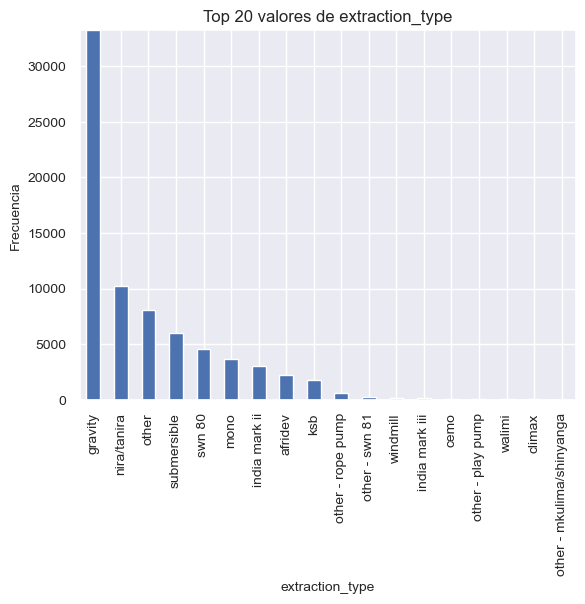

In [23]:
print(data.extraction_type.value_counts().head(20))
plot_top_categories(data, 'extraction_type', 20)

#### - 1 funder

Variable que nos indica quien financió el pozo. Observamos algunos valores extraños como el valor 0 con 980 valores, sin embargo al ser uan categoría tan predominante no nos interesa modificarla, la mantendremos como está y bastantes valores NA, 4507. Además hay una gran concentración en el valor Government Of Tanzania

In [24]:
# Contar el número de categorías diferentes en la variable 'funder'
num_categories = data['funder'].nunique()
print("Número de categorías diferentes en la variable 'funder':", num_categories)

Número de categorías diferentes en la variable 'funder': 2139


In [25]:
print(data.funder.value_counts().head(20))

funder
Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1324
Tasaf                      1136
Dhv                        1065
District Council           1037
Private Individual         1034
Dwsp                       1012
0                           980
Norad                       949
Germany Republi             765
Water                       739
Tcrs                        735
Ministry Of Water           728
Dwe                         605
Name: count, dtype: int64


In [26]:
print ('Valores NA de variable funder:', data.funder.isnull().sum())

Valores NA de variable funder: 4507


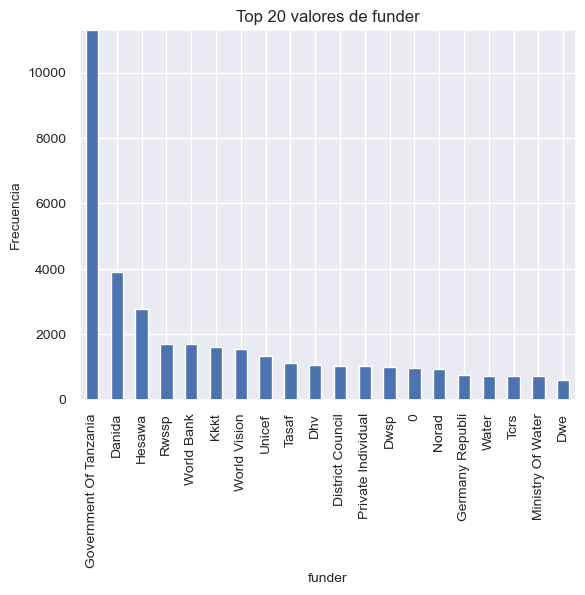

In [27]:
# Grafica de top categorias
plot_top_categories(data, 'funder', 20)

En cuanto a los valores NA, decido hacer imputaciones, creando un nuevo grupo denominado 'Uknown'. Comprobando previamente que ya existe ese grupo y que tiene 5 registros.

In [28]:
# Calcula el conteo de cada valor en la columna 'funder'
print('Valores "Unknown" de la variable installer:', (data['funder'] == 'Unknown').sum())

Valores "Unknown" de la variable installer: 5


In [29]:
data['funder'].fillna('Unknown',inplace=True)

Comprobamos que ahora la categoría Uknown tiene 4512 valores. Los 4507 NA + los 5 que tenia previamente.

In [30]:
print(data.funder.value_counts().head(20))
print('Registros de funder con valor NA: ',data.funder.isnull().sum())

funder
Government Of Tanzania    11299
Unknown                    4512
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1324
Tasaf                      1136
Dhv                        1065
District Council           1037
Private Individual         1034
Dwsp                       1012
0                           980
Norad                       949
Germany Republi             765
Water                       739
Tcrs                        735
Ministry Of Water           728
Name: count, dtype: int64
Registros de funder con valor NA:  0


#### - 2 installer

Variable que indica la organización que instaló el pozo. Se observa que la variable tiene 2410 categorías diferentes, cuya distribución guarda bastante parecido con funder, y que por ejemplo la categoría 0, tiene el mismo número de registros que la categoría de funder, esto nos da indicios que existe algun tipo de correlación entre las 2 variables.

In [31]:
# Contar el número de categorías diferentes en la variable 'funder'
num_categories = data['installer'].nunique()
print("Número de categorías diferentes en la variable 'installer':", num_categories)

Número de categorías diferentes en la variable 'installer': 2410


In [32]:
data['installer'].value_counts().head(20)

installer
DWE                   21751
Government             2282
RWE                    1498
Commu                  1347
DANIDA                 1305
KKKT                   1120
Hesawa                 1070
0                       980
TCRS                    887
CES                     765
Central government      764
DANID                   690
Community               687
HESAWA                  679
District Council        663
World vision            517
TASAF                   504
LGA                     501
WEDECO                  496
District council        490
Name: count, dtype: int64

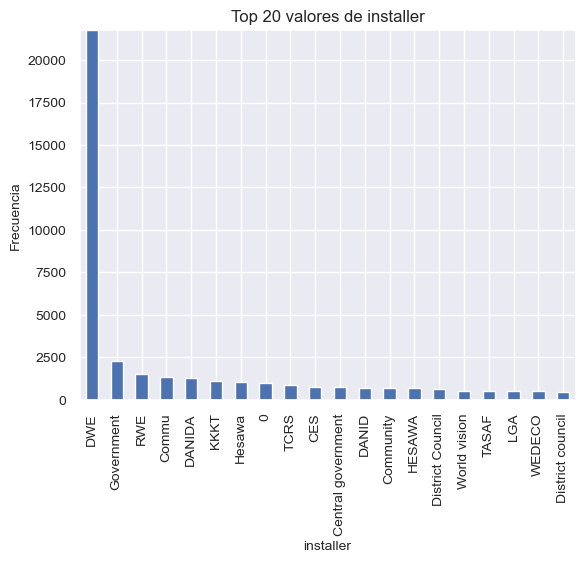

In [33]:
# Grafica de top categorias
plot_top_categories(data, 'installer', 20)

In [34]:
print ('Valores NA de variable installer:', data.installer.isnull().sum())

Valores NA de variable installer: 4532


En cuanto a los valores NA, decido hacer imputaciones, creando un nuevo grupo denominado 'Uknown'. Comprobando previamente que ya existe ese grupo y que tiene 4 registros.

In [35]:
print('Valores "Unknown" de la variable installer:', (data['installer'] == 'Unknown').sum())

Valores "Unknown" de la variable installer: 4


In [36]:
data['installer'].fillna('Unknown',inplace=True)

Comprobamos que ahora la categoría Uknown tiene 4536 valores. Los 4532 NA + los 4 que tenia previamente.

In [37]:
print(data.installer.value_counts().head(20))
print('Registros de installer con valor NA: ',data.installer.isnull().sum())

installer
DWE                   21751
Unknown                4536
Government             2282
RWE                    1498
Commu                  1347
DANIDA                 1305
KKKT                   1120
Hesawa                 1070
0                       980
TCRS                    887
CES                     765
Central government      764
DANID                   690
Community               687
HESAWA                  679
District Council        663
World vision            517
TASAF                   504
LGA                     501
WEDECO                  496
Name: count, dtype: int64
Registros de installer con valor NA:  0


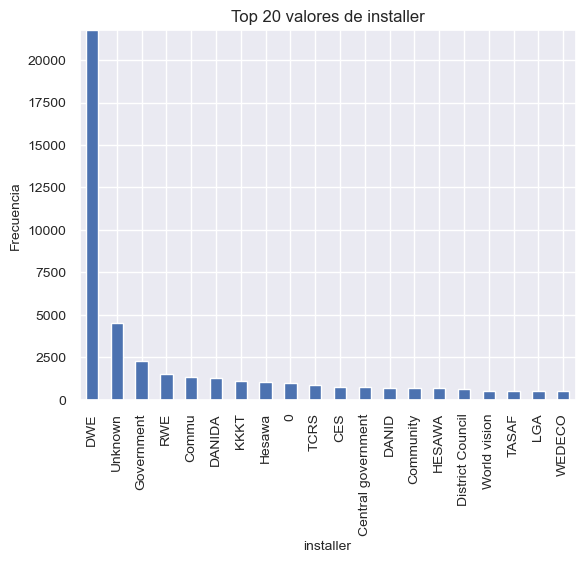

In [38]:
# Grafica de top categorias
plot_top_categories(data, 'installer', 20)

Tenemos 11573 registros que comparten valores de funder e installer, es interesante comprobar la correlación entre ambas variables. 
No nos interesa que haya variables que presenten correlacion entre ellas, esto puede dar lugar a generar una nueva variable que exponga la relacion entre ambas.

In [39]:
# Verifica si los registros tienen el mismo ID en las columnas 'funder' e 'installer'
misma_id = (data['funder'] == data['installer']).value_counts()

# Imprime el resultado
print('Registros con similares valores en funder e installer, con el mismo ID:', misma_id.get(True, 0))

Registros con similares valores en funder e installer, con el mismo ID: 11573


#### - 3 wpt_name

Esta variable, indica el nombre del punto de agua. Se puede comprobar como grupo mayoritario none, que interpreto como nombre no identificado. Como tenemos solo 2 valores NA en esta variable, los decido imputar al grupo none directamente.

In [40]:
print(data.wpt_name.value_counts().head(10))

wpt_name
none               4440
Shuleni            2183
Zahanati           1034
Msikitini           647
Kanisani            390
Sokoni              328
Bombani             323
Ofisini             321
School              260
Shule Ya Msingi     247
Name: count, dtype: int64


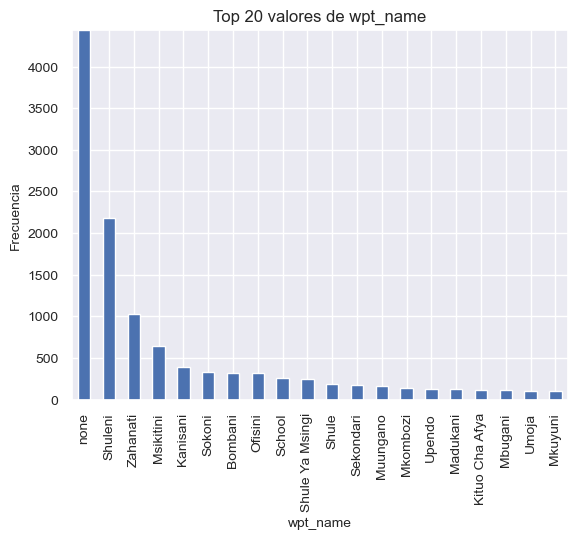

In [41]:
# Grafica de top categorias
plot_top_categories(data, 'wpt_name', 20)

In [42]:
print ('Valores NA de variable wpt_name:', data.wpt_name.isnull().sum())

Valores NA de variable wpt_name: 2


In [43]:
data['wpt_name'].fillna('none',inplace=True)
print ('Valores NA de variable wpt_name:', data.wpt_name.isnull().sum())

Valores NA de variable wpt_name: 0


#### - 4 basin

Cuenca hidrográfica geográfica

basin
Lake Victoria              12871
Pangani                    11143
Rufiji                      9987
Internal                    9642
Lake Tanganyika             8052
Wami / Ruvu                 7577
Lake Nyasa                  6332
Ruvuma / Southern Coast     5587
Lake Rukwa                  3059
Name: count, dtype: int64


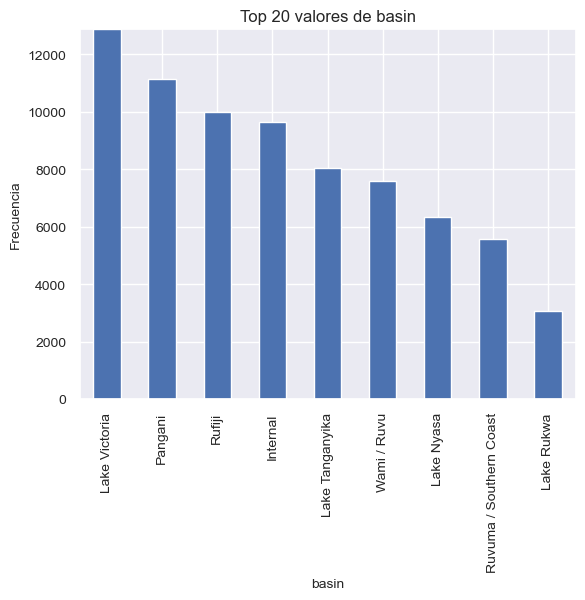

In [44]:
# Grafica de top categorias
print(data.basin.value_counts().head(20))
plot_top_categories(data, 'basin', 20)

#### - 5 subvillage

Variable que indica la localización geográfica. Vemos que tiene una serie de categorías con una sola letra como por ejemplo 'M' o '1', y obviamente no existen esas localizaciones, sin embargo, al haber tantos registros en cada una de esas categorías, a nivel de datos y distribución estimo que son igual de valida que cualquier otra. Se podrían meter todas en la categoría Uknown, pero el hecho de que haya varias y todas ellas con bastantes registros da indicios de que son igual de validas respecto a la distribución como cualquier otra categoría, en conclusion, se mantienen estas categorías, y se realiza la imputación de los NA a 'Uknown'.

In [45]:
print(data.subvillage.value_counts().head(20))

subvillage
Shuleni       646
Majengo       631
Madukani      629
Kati          467
Mtakuja       322
Sokoni        294
M             243
Muungano      215
Mbuyuni       210
Songambele    194
Mlimani       190
Miembeni      168
Msikitini     164
1             157
Kanisani      146
Kibaoni       143
Mjini         131
Mjimwema      129
Mapinduzi     126
Mkwajuni      125
Name: count, dtype: int64


In [46]:
print('Registros con subvillage de valor NA: ',data.subvillage.isnull().sum())

Registros con subvillage de valor NA:  470


subvillage
Shuleni       646
Majengo       631
Madukani      629
Kati          467
Mtakuja       322
Sokoni        294
M             243
Muungano      215
Mbuyuni       210
Songambele    194
Mlimani       190
Miembeni      168
Msikitini     164
1             157
Kanisani      146
Kibaoni       143
Mjini         131
Mjimwema      129
Mapinduzi     126
Mkwajuni      125
Name: count, dtype: int64


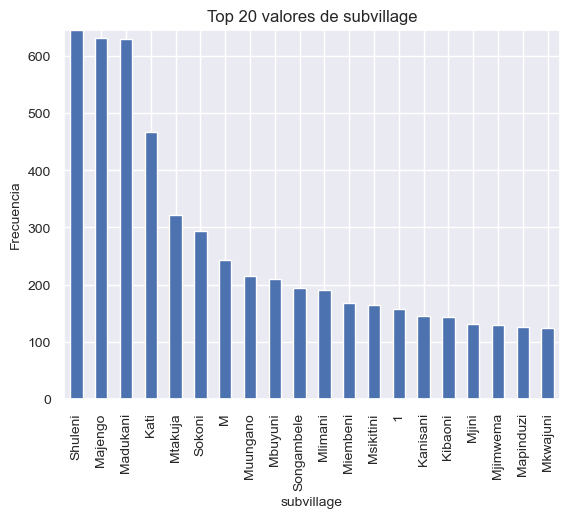

In [47]:
# Grafica de top categorias
print(data.subvillage.value_counts().head(20))
plot_top_categories(data, 'subvillage', 20)

In [48]:
#Imputación de los NA por 'Uknown'
data['subvillage'].fillna('Uknown',inplace=True)

print(data.subvillage.value_counts().head(20))

subvillage
Shuleni       646
Majengo       631
Madukani      629
Uknown        470
Kati          467
Mtakuja       322
Sokoni        294
M             243
Muungano      215
Mbuyuni       210
Songambele    194
Mlimani       190
Miembeni      168
Msikitini     164
1             157
Kanisani      146
Kibaoni       143
Mjini         131
Mjimwema      129
Mapinduzi     126
Name: count, dtype: int64


Una vez hechas las imputaciones, vemos la categoría Uknown dentro de la distribución con todos los registros que previamente eran NA.

subvillage
Shuleni       646
Majengo       631
Madukani      629
Uknown        470
Kati          467
Mtakuja       322
Sokoni        294
M             243
Muungano      215
Mbuyuni       210
Songambele    194
Mlimani       190
Miembeni      168
Msikitini     164
1             157
Kanisani      146
Kibaoni       143
Mjini         131
Mjimwema      129
Mapinduzi     126
Name: count, dtype: int64


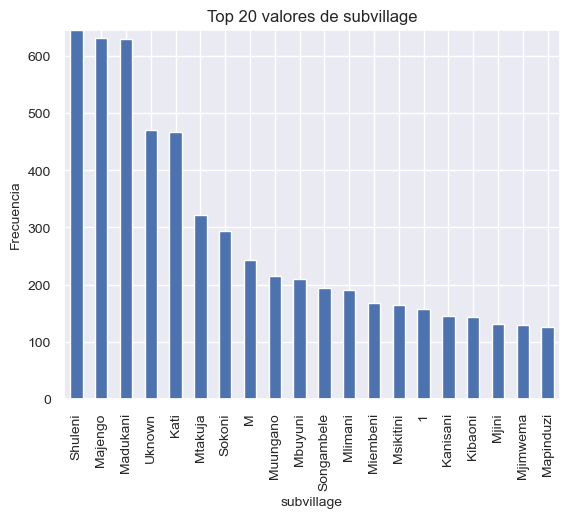

In [49]:
# Grafica de top categorias
print(data.subvillage.value_counts().head(20))
plot_top_categories(data, 'subvillage', 20)

#### - 6 region

Variable que indica la situación geográfica del punto de agua.

region
Iringa         6599
Shinyanga      6293
Mbeya          5758
Kilimanjaro    5494
Morogoro       5038
Kagera         4174
Arusha         4111
Mwanza         3897
Kigoma         3533
Pwani          3331
Ruvuma         3306
Tanga          3186
Dodoma         2779
Singida        2536
Tabora         2466
Mara           2451
Rukwa          2242
Mtwara         2144
Manyara        1972
Lindi          1920
Name: count, dtype: int64


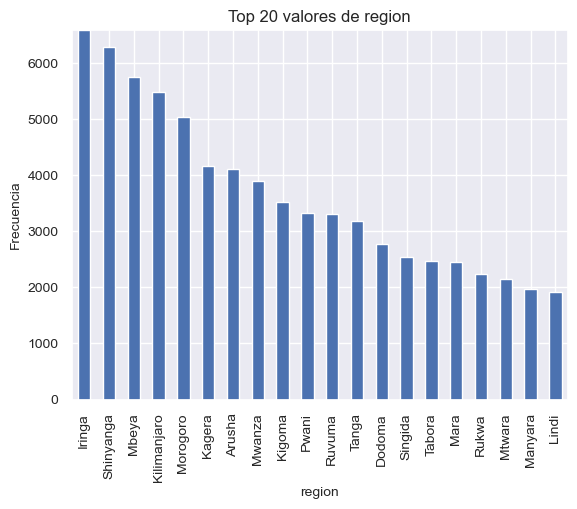

In [50]:
# Grafica de top categorias
print(data.region.value_counts().head(20))
plot_top_categories(data, 'region', 20)

#### - 7 lga

Variable que indica la situación geográfica del punto de agua.

lga
Njombe           3128
Moshi Rural      1566
Arusha Rural     1521
Bariadi          1485
Rungwe           1381
Kilosa           1368
Kasulu           1322
Mbozi            1286
Bagamoyo         1263
Meru             1244
Kilombero        1207
Singida Rural    1202
Same             1106
Kibondo          1101
Kyela            1070
Kahama           1058
Magu             1049
Maswa            1024
Kigoma Rural     1015
Karagwe           967
Name: count, dtype: int64


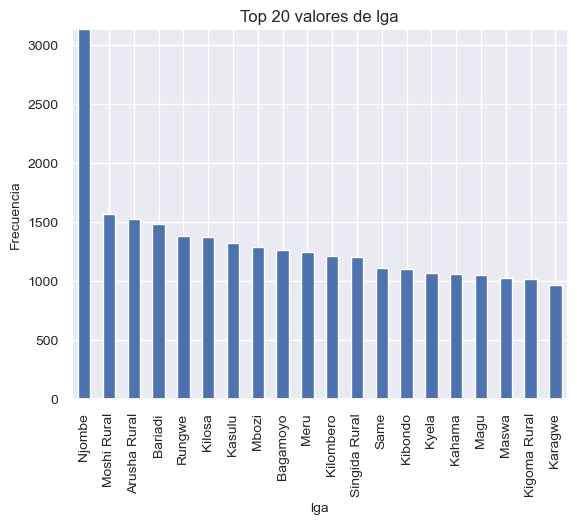

In [51]:
# Grafica de top categorias
print(data.lga.value_counts().head(20))
plot_top_categories(data, 'lga', 20)

#### - 8 ward

Variable que indica la situación geográfica del punto de agua.

ward
Igosi            386
Imalinyi         318
Siha Kati        297
Mdandu           292
Nduruma          261
Kitunda          260
Mishamo          251
Msindo           243
Chalinze         238
Maji ya Chai     227
Usuka            222
Chanika          221
Ngarenanyuki     212
Vikindu          199
Mtwango          189
Zinga/Ikerege    185
Itete            179
Matola           177
Magomeni         170
Maramba          167
Name: count, dtype: int64


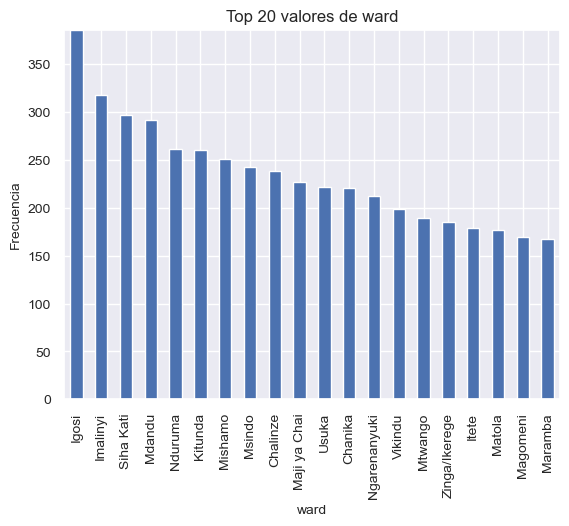

In [52]:
# Grafica de top categorias
print(data.ward.value_counts().head(20))
plot_top_categories(data, 'ward', 20)

#### - 9 public_meeting

Variable True o False, no se nos da mayor información,aunque se deduce que indica si es un punto de agua público o no.

In [53]:
print(data.public_meeting.value_counts().head())

public_meeting
True     63749
False     6346
Name: count, dtype: int64


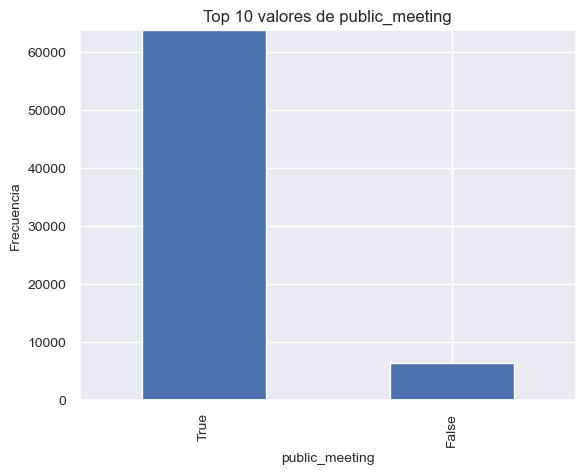

In [54]:
# Grafica de top categorias
plot_top_categories(data, 'public_meeting', 10)

In [55]:
print('Registros con public_meeting valor NA: ',data.public_meeting.isnull().sum())

Registros con public_meeting valor NA:  4155


A la hora de realizar las imputaciones, se plantean 3 estrategias diferentes:
- Imputar por Moda, y como resultado tendríamos que todos los registros NA pasarían a valer True
- Imputar respetando la distribución de los registros, por lo tanto sacaríamos la probabilidad de pertenecer a cada uno de los dos grupos, y imputaremos siguiendo ese porcentaje, alrededor del 90% de lso valores NA se convertirían en True y el 10% en False
- Crear una nueva categoria 'Unknown' donde imputaríamos todos los NA. Obtendríamos así 3 categorías dentro de la variable True, False, y Unknow.

Despues de probar los score de las 3 estrategías decido mantener la 3ª creando una nueva categoría 'Unknown'. Aunque en un primer momento parece ser la opcion menos favorale, los resultados indican que es la más consecuente respecto a la distribución de la variable. (SE DEJA EL CÓDIGO DE LAS DEMAS OPCIONES EN RAW)

In [56]:
# Convertir NA a Unknown

data['public_meeting'].fillna('Uknown',inplace=True)

print(data.public_meeting.value_counts().head())
print('Registros con public_meeting valor NA: ',data.public_meeting.isnull().sum())

public_meeting
True      63749
False      6346
Uknown     4155
Name: count, dtype: int64
Registros con public_meeting valor NA:  0


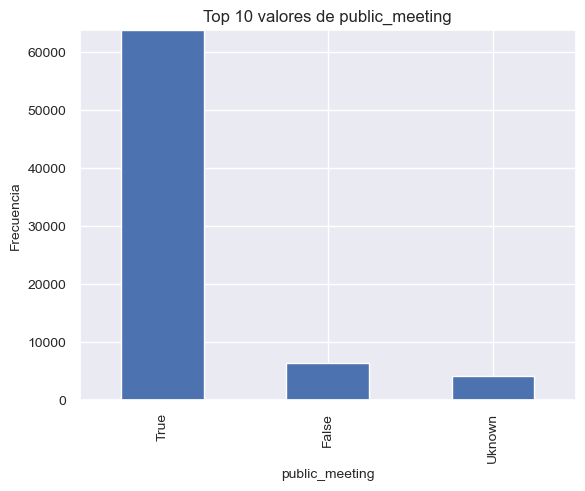

In [57]:
# Grafica de top categorias
plot_top_categories(data, 'public_meeting', 10)

#### - 10 recorded_by

Variable que indica quien guardo ese registro. Variable con un solo valor, que no aporta nada al modelo, se elimina del dataset a borrarla.

In [58]:
print(data.recorded_by.value_counts().head())

recorded_by
GeoData Consultants Ltd    74250
Name: count, dtype: int64


In [59]:
#Borrar recorded_by del dataset
data = data.drop(['recorded_by'],axis=1)

# Restablecer el índice del DataFrame
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 74250 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              74250 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74250 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             74250 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

#### - 11 scheme_management

Variable que indica quien opera el punto de agua. Variable con 11 categorías las cuales no vemos ningun problema, más allá de los valores NA.

Aunque se puede ver la categoria Other, decido no imputar en esta categoria los valores NA, sino crear una nueva 'Unknown'. Según la interpretacion de Other, esta categoría debería implicar que el punto de agua tiene un scheme_management diferente a las de las demás categorías. Por lo tanto, los NA que imputamos, en realidad podrían pertenecer a cualquiera categoría, Other representa una categoría diferente a las demás, por lo que los valores NA pueden estar distribuidos en cualquiera de ellas en realidad. La distribucion de Unknown puede plantear una correlación con las demás, siendo Other una de ellas.

- Se decide hacer una imputación de NA a 'Unknown'

- Otro punto a destacar sería unir las categorias Other con SWC y Trust, pero según los resultados obtenidos, esto proboca un modelo menos preciso, por lo que se decide evitar este paso. (SE DEJA EL CODIGO EN RAW)

In [60]:
print(data.scheme_management.value_counts().head(20))

scheme_management
VWC                 45917
WUG                  6496
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
Name: count, dtype: int64


In [61]:
print('Registros con scheme_management valor NA: ',data.scheme_management.isnull().sum())

Registros con scheme_management valor NA:  4847


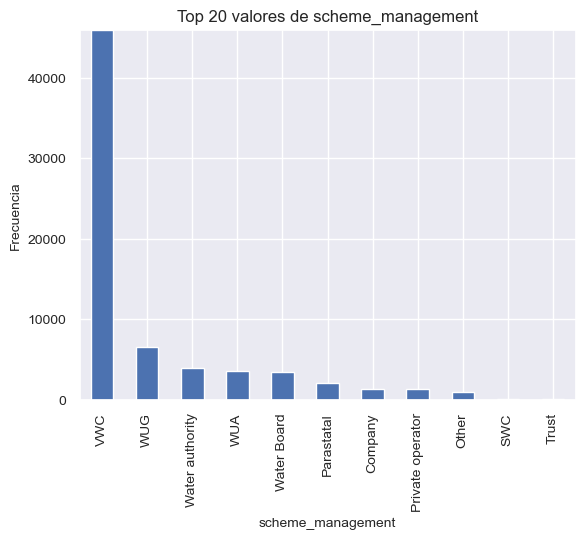

In [62]:
# Grafica de top categorias
plot_top_categories(data, 'scheme_management', 20)

In [63]:
#Conversión NA a 'Unknown'
data['scheme_management'].fillna('Uknown',inplace=True)
print('Registros con scheme_management valor NA: ',data.scheme_management.isnull().sum())

Registros con scheme_management valor NA:  0


#### - 12 scheme_name

Variable que indica quien opera el punto de agua. Presenta la característica de tener categorías con un solo caracter, que a priori nos da indicios de que son incorrectas. Podríamos aunar dichas categorías en una, pero como vimos con anterioridad en la variable subvillage que presentaba la misma circunstancia, estas categorías con tantos registros conforman un patrón dentro de la variable por lo que se van a mantener. Se decide imputar las variables NA por 'Unknown' de nuevo.

In [64]:
print(data.scheme_name.value_counts().head(20))
print('Registros con scheme_name valor NA: ',data.scheme_name.isnull().sum())

scheme_name
K                                        858
Borehole                                 704
Chalinze wate                            501
M                                        490
DANIDA                                   483
Government                               395
Ngana water supplied scheme              335
wanging'ombe water supply s              323
Bagamoyo wate                            296
wanging'ombe supply scheme               284
I                                        281
Uroki-Bomang'ombe water sup              266
N                                        258
Kirua kahe gravity water supply trust    237
Machumba estate pipe line                225
Makwale water supplied sche              209
Kijiji                                   205
Handeni Trunk Main(H                     204
S                                        188
Losaa-Kia water supply                   184
Name: count, dtype: int64
Registros con scheme_name valor NA:  36052


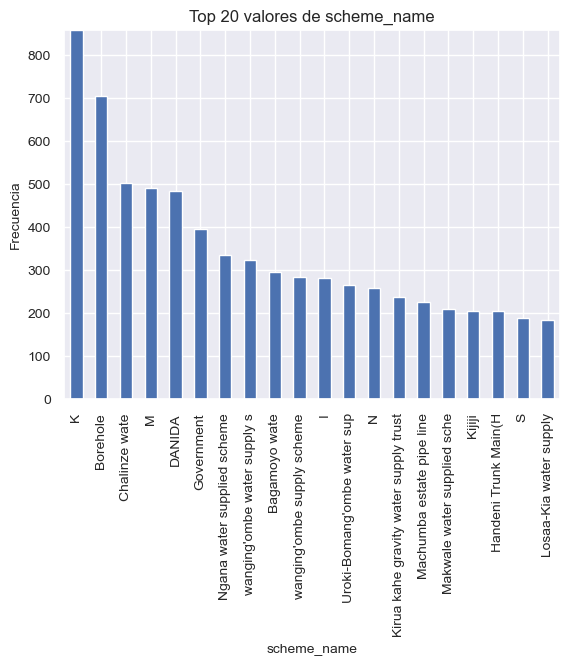

In [65]:
# Grafica de top categorias
plot_top_categories(data, 'scheme_name', 20)

In [66]:
# Verificar la cantidad de registros con valor "none" en scheme_name
print('Registros con scheme_name valor "none": ', (data['scheme_name'] == 'none').sum())

Registros con scheme_name valor "none":  34


In [67]:
data['scheme_name'].fillna('Uknown',inplace=True)
print(data.scheme_name.value_counts().head(10))
print('Registros con scheme_name valor NA: ',data.scheme_name.isnull().sum())

scheme_name
Uknown                         36052
K                                858
Borehole                         704
Chalinze wate                    501
M                                490
DANIDA                           483
Government                       395
Ngana water supplied scheme      335
wanging'ombe water supply s      323
Bagamoyo wate                    296
Name: count, dtype: int64
Registros con scheme_name valor NA:  0


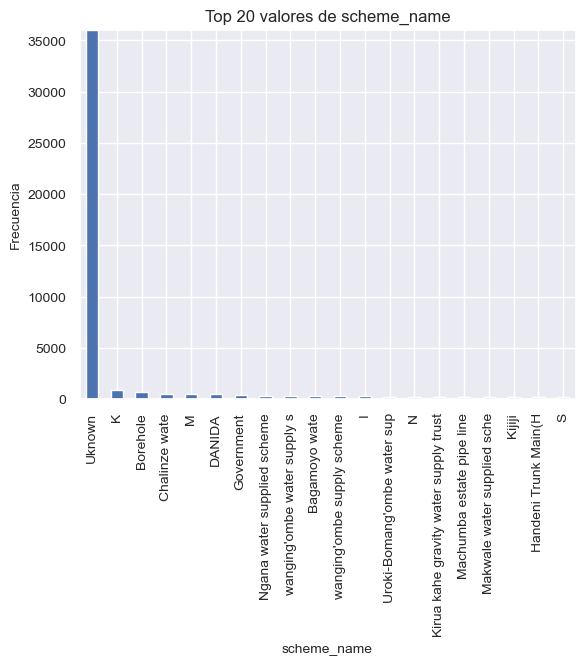

In [68]:
# Grafica de top categorias
plot_top_categories(data, 'scheme_name', 20)

La distribucion que presenta después de la imputación, puede dar lugar a convertirse en una categoría con 2 valores Knwon y Unknown, ya que la categoría Uknown presenta alrededor el 50% de la distribución.

#### - 13  permit

Variable dicotómica que nos indica si el punto de agua está permitido o no. 

In [69]:
print(data.permit.value_counts().head(10))
print('Registros con permit valor NA: ',data.permit.isnull().sum())

permit
True     48606
False    21851
Name: count, dtype: int64
Registros con permit valor NA:  3793


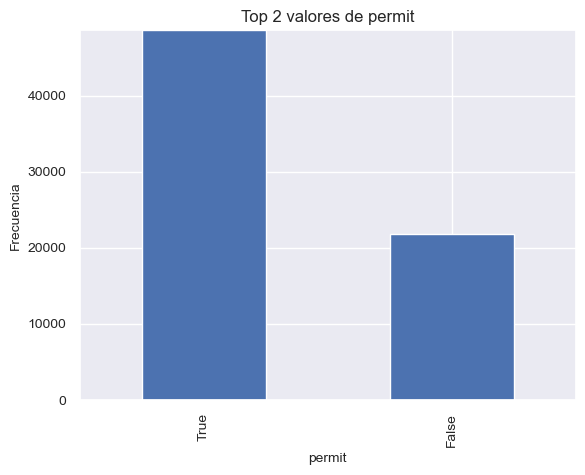

In [70]:
# Grafica de top categorias
plot_top_categories(data, 'permit', 2)

Decido convertir los registros NA a Unknown

In [71]:
data['permit'].fillna('Uknown',inplace=True)
print(data.permit.value_counts().head(10))
print('Registros con scheme_name valor NA: ',data.permit.isnull().sum())

permit
True      48606
False     21851
Uknown     3793
Name: count, dtype: int64
Registros con scheme_name valor NA:  0


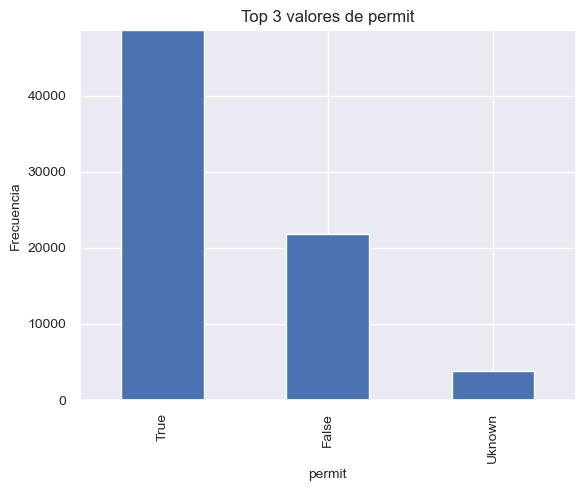

In [72]:
# Grafica de top categorias
plot_top_categories(data, 'permit', 3)

#### - 14 extraction_type

Variable que indica el tipo de extraccion de agua.

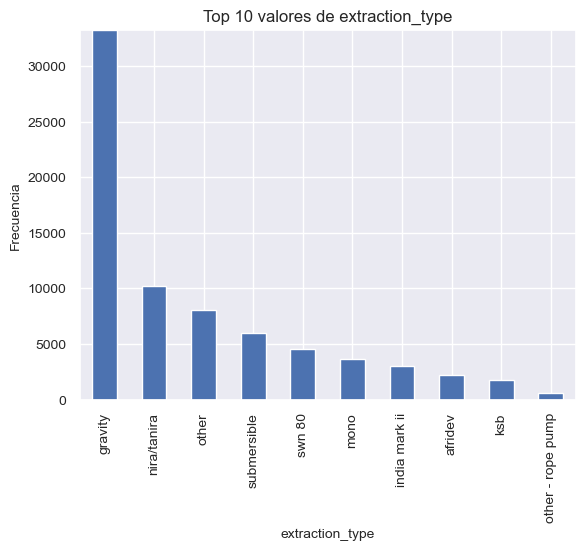

In [73]:
# Grafica de top categorias
plot_top_categories(data, 'extraction_type', 10)

#### - 15  extraction_type_group

Variable que indica el tipo de extracción que utiliza el punto de agua

extraction_type_group
gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: count, dtype: int64


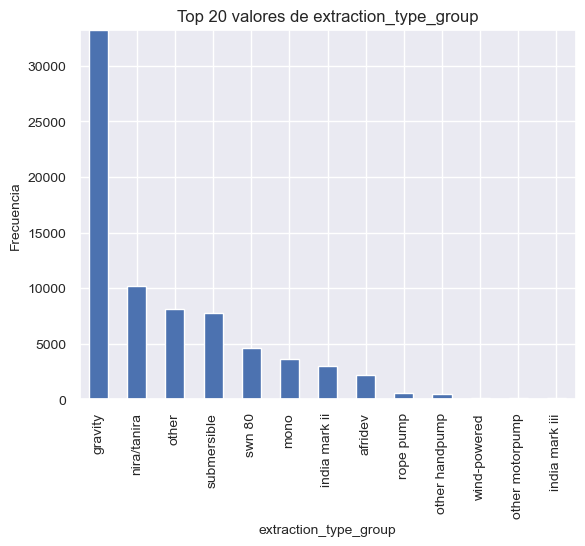

In [74]:
# Grafica de top categorias
print(data.extraction_type_group.value_counts().head(20))
plot_top_categories(data, 'extraction_type_group', 20)

#### - 16 extraction_type_class

Variable que indica el tipo de extracción que utiliza el punto de agua

extraction_type_group
gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: count, dtype: int64


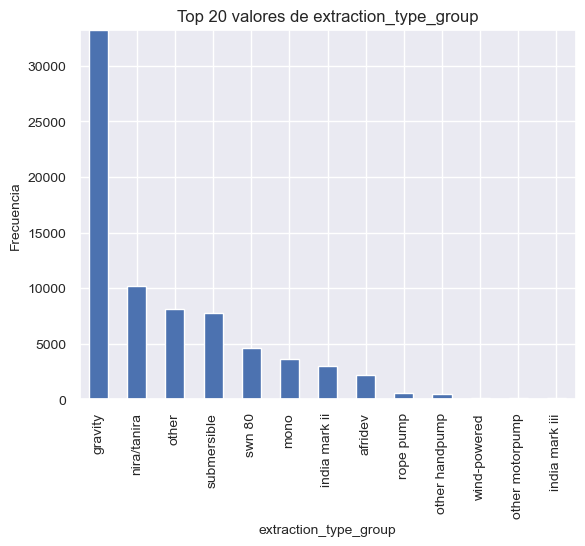

In [75]:
# Grafica de top categorias
print(data.extraction_type_group.value_counts().head(20))
plot_top_categories(data, 'extraction_type_group', 20)

#### - 17  management

Variable que indica como se gestiona el punto de agua

management
vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: count, dtype: int64


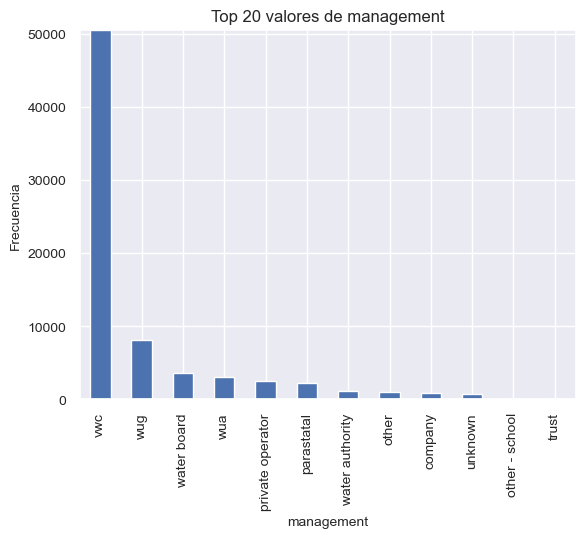

In [76]:
# Grafica de top categorias
print(data.management.value_counts().head(20))
plot_top_categories(data, 'management', 20)

#### - 18  management_group

Variable que indica como se gestiona el punto de agua

management
vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: count, dtype: int64


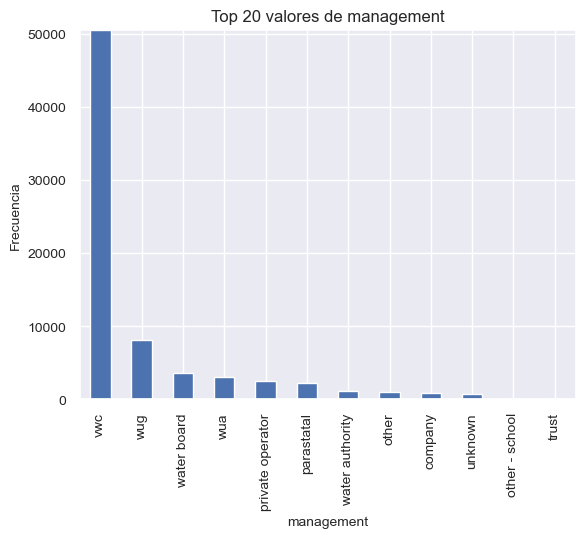

In [77]:
# Grafica de top categorias
print(data.management.value_counts().head(20))
plot_top_categories(data, 'management', 20)

#### - 19  payment

Variable que indica cuanto cuesta el agua

payment
never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: count, dtype: int64


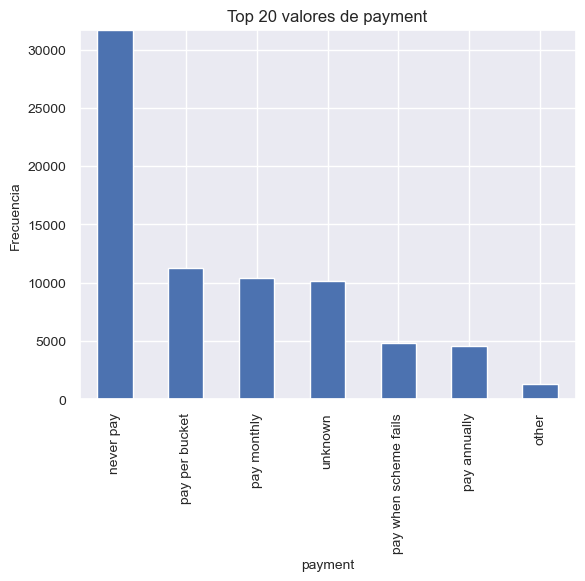

In [78]:
print(data.payment.value_counts().head(20))
plot_top_categories(data, 'payment', 20)

#### - 20  payment_type

Variable que indica cuanto cuesta el punto de agua

payment_type
never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: count, dtype: int64


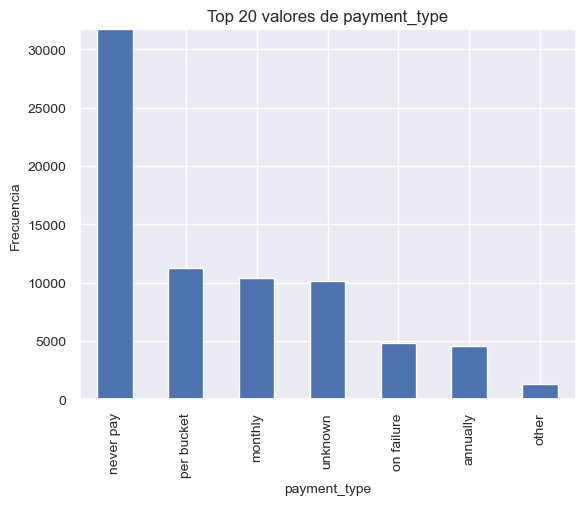

In [79]:
print(data.payment_type.value_counts().head(20))
plot_top_categories(data, 'payment_type', 20)

#### - 21  water_quality

Variable que indica la calidad del agua

water_quality
soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: count, dtype: int64


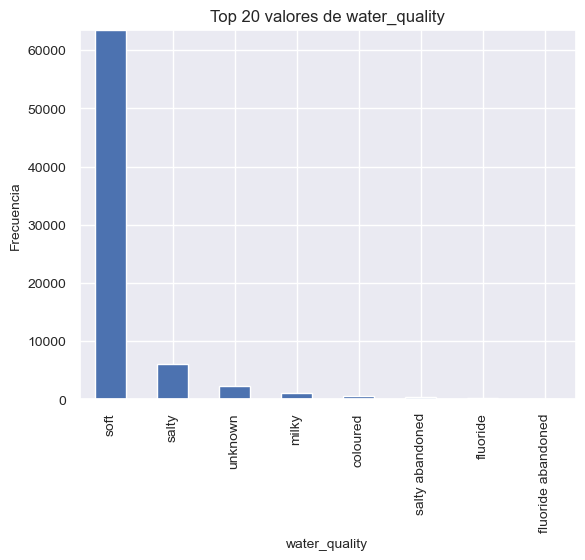

In [80]:
# Grafica de top categorias
print(data.water_quality.value_counts().head(20))
plot_top_categories(data, 'water_quality', 20)

#### - 22  quality_group

Variable que nos indica la caldiad del agua

quality_group
good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: count, dtype: int64


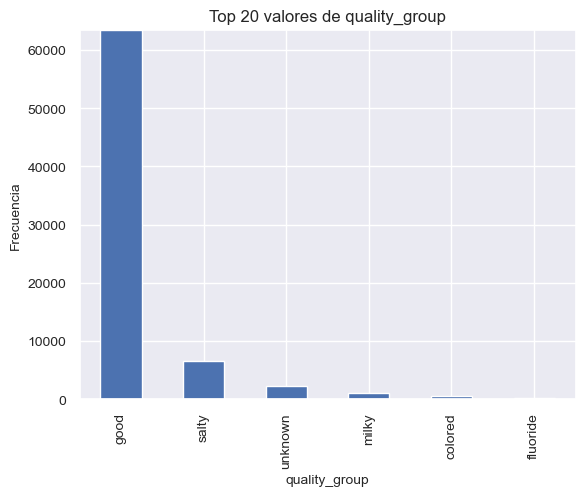

In [81]:
print(data.quality_group.value_counts().head(20))
plot_top_categories(data, 'quality_group', 20)

#### - 23  quantity

Variable que nos indica la caldiad del agua

quantity
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


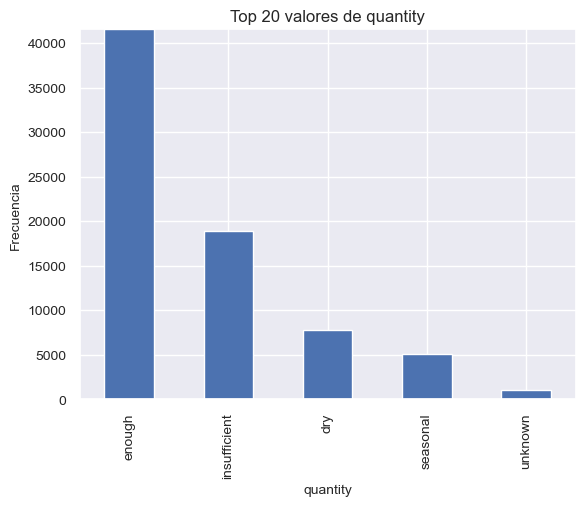

In [82]:
print(data.quantity.value_counts().head(20))
plot_top_categories(data, 'quantity', 20)

#### - 24  quantity_group

Variable que nos indica la caldiad del agua

quantity_group
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


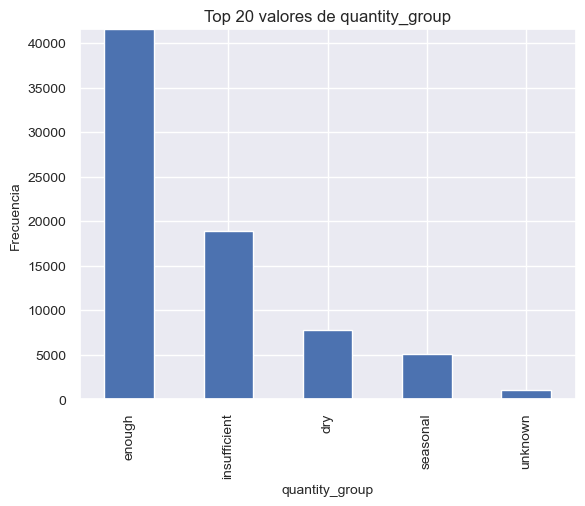

In [83]:
print(data.quantity_group.value_counts().head(20))
plot_top_categories(data, 'quantity_group', 20)

#### - 25 source

Variable que nos indica el origen del agua.

source
spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: count, dtype: int64


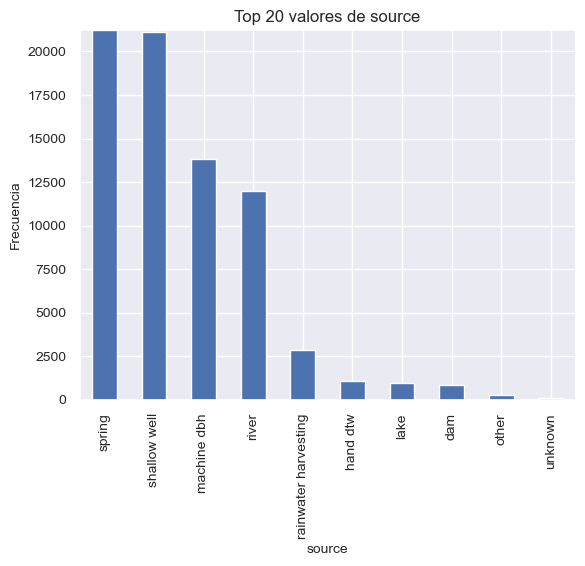

In [84]:
print(data.source.value_counts().head(20))
plot_top_categories(data, 'source', 20)

#### - 26  source_type

Variable que nos indica el origen del agua.

source_type
spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: count, dtype: int64


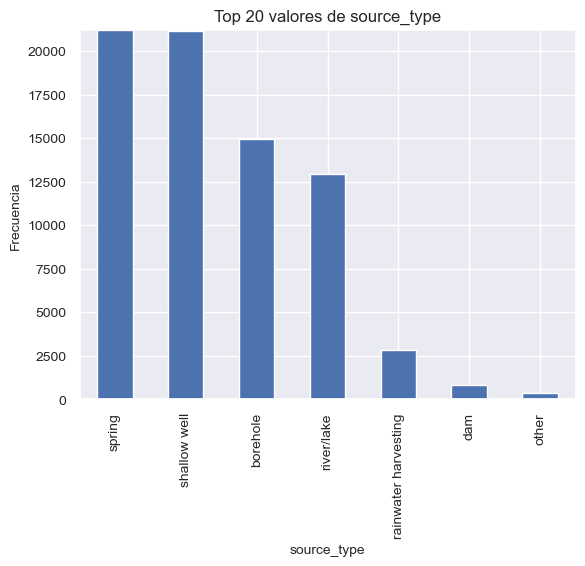

In [85]:
print(data.source_type.value_counts().head(20))
plot_top_categories(data, 'source_type', 20)

#### - 27  source_class

Variable que nos indica el origen del agua.

source_type
spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: count, dtype: int64


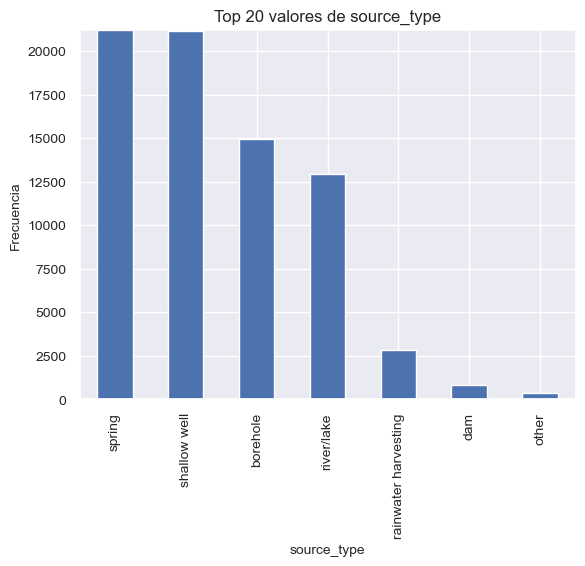

In [86]:
print(data.source_type.value_counts().head(20))
plot_top_categories(data, 'source_type', 20)

#### - 28  waterpoint_type

Variable que indica el tipo de punto de agua

waterpoint_type
communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: count, dtype: int64


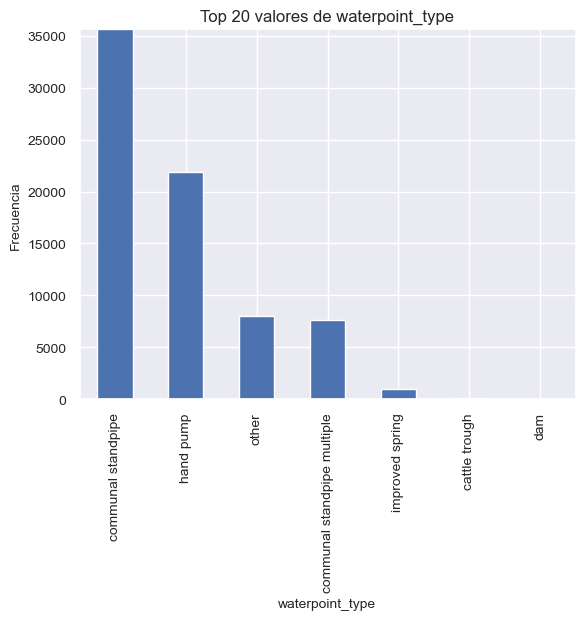

In [87]:
print(data.waterpoint_type.value_counts().head(20))
plot_top_categories(data, 'waterpoint_type', 20)

#### - 29  waterpoint_type_group

Variable que indica el tipo de punto de agua

waterpoint_type
communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: count, dtype: int64


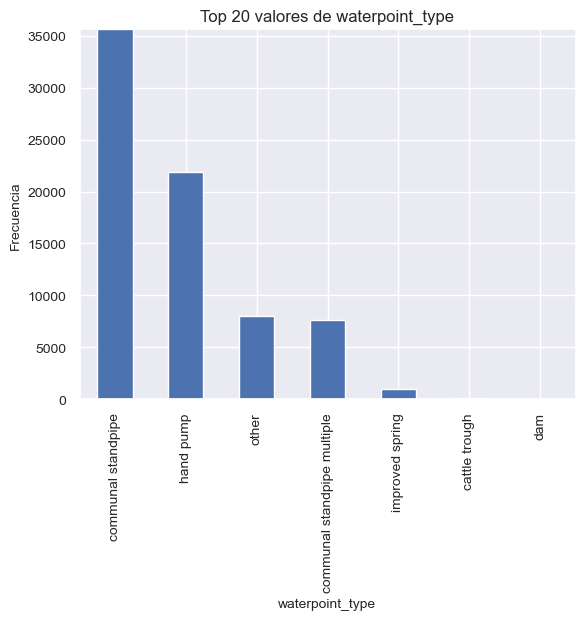

In [88]:
print(data.waterpoint_type.value_counts().head(20))
plot_top_categories(data, 'waterpoint_type', 20)

In [89]:
print("Variables con valores nulos NA:\n")
print(data.isnull().sum())

Variables con valores nulos NA:

id                           0
amount_tsh                   0
date_recorded                0
funder                       0
gps_height                   0
installer                    0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting               0
scheme_management            0
scheme_name                  0
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
qualit

### 1.3.2. Gestion de outlayers

A la hora de ver que variables tienen outlayers, nos vamos a fijar en las variables numéricas, las variables categóricas no tiene sentido analizarlas ya que no tienen valroes continuos sino categorias.
Aunque más adelante se tengan que convertir esas categorias a números, seguiran siendo representaciones de categorías por lo que no tendrá sentido buscar outlayers en las variables categóricas.

id


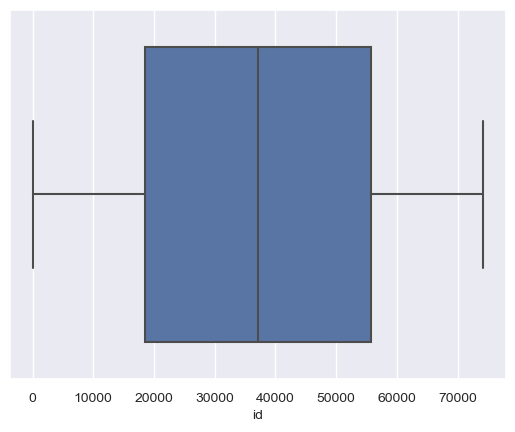

amount_tsh


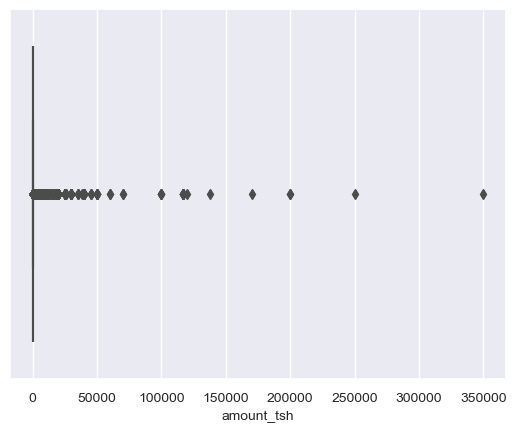

gps_height


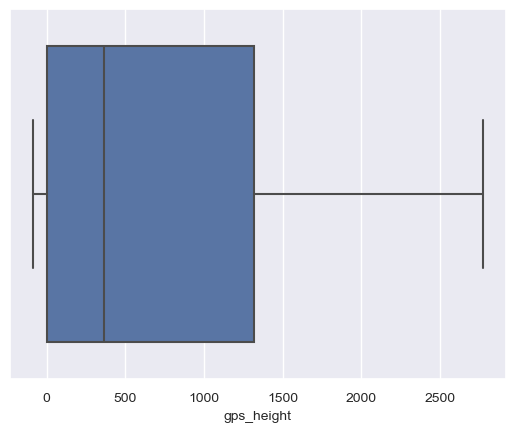

longitude


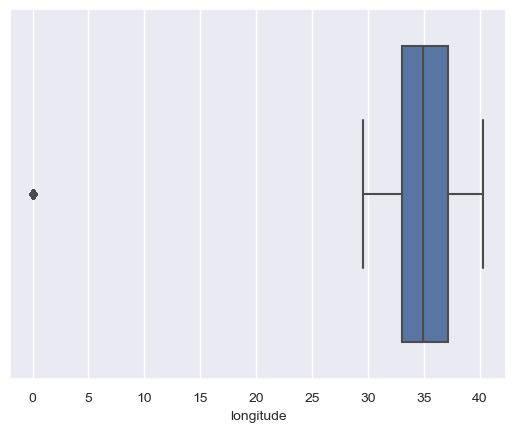

latitude


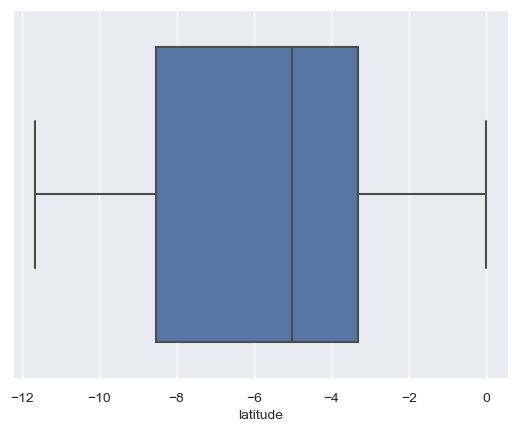

num_private


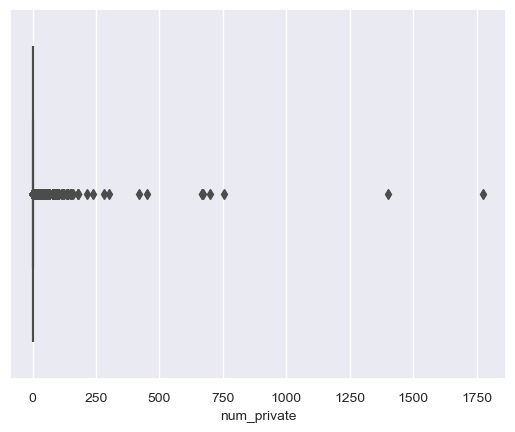

region_code


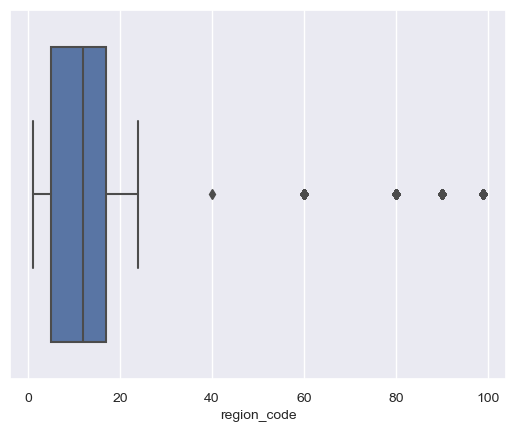

district_code


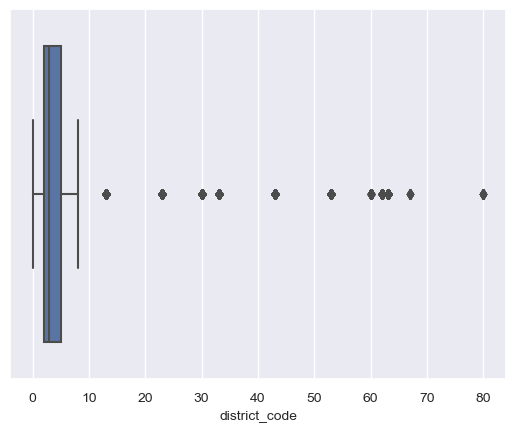

population


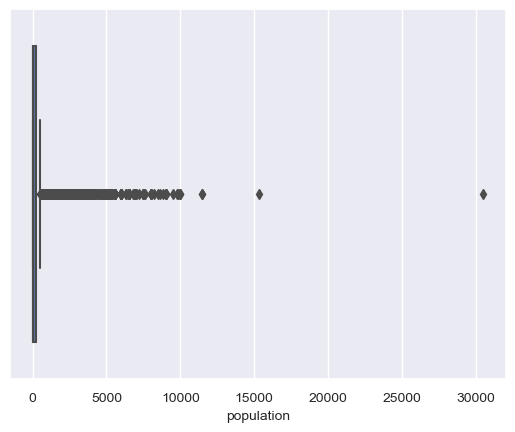

construction_year


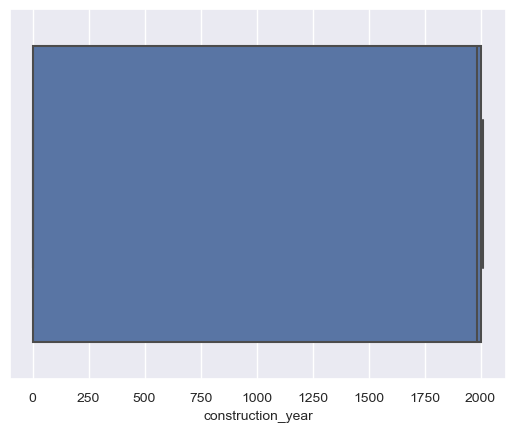

In [90]:
# Mostrar grafico de boxplot para graficar outliers
for i in data[num_cols]:
    sns.boxplot(x=data[i])
    print(i)
    plt.show()

Vamos a analizar todas las variables que hemos visto que tienen outliers, para entender su naturaleza y saber si son datos que se salen de lo normal o que  nos interesa mantener.

#### - 1 - amount_tsh (RAW)
Variable que nos indica la cantidad de agua disponibel en el punto de agua. Al ver su distribución vemos que tiene un 60% de los registros con valor 0, esto hace que aparezcan tantos outliers, hay demasiada diferencia entre los valores. Sin embargo creo que estos son correctos, pero para darle peso a los valores distintos dentro de la distribución, decido convertirla en una variable dicotomica amount_tsh_binary donde valga 0 si amount_tsh = 0, y valga 1 si amount_tsh != 0.

Se ha comprobado que baja la puntuación del modelo, por lo que se deja en RAW

#### - 2 -  longitude
Coordenadas GPS de longitud

Se ve que hay longitudes con valor 0, es decir, tenemos datos erroneos. podemos o imputar según la moda/media, o imputar aleatoriamente siguiendo la distribución, o eliminar los registros.

En este caso voy a imputar por moda, además voy a convertir el valor longitud a entero, así consigo estratificar la variable y poder imputar los outliers facilmente.

In [91]:
data['longitude'] = data['longitude'].astype(int)

In [92]:
# Ordenar el numero de valores de la columna 'longitude', y los cuenta
print(data['longitude'].value_counts().sort_index())


longitude
0      2269
29     1273
30     4182
31     4643
32     5171
33    10117
34    10527
35     7656
36     8136
37     8679
38     6568
39     4628
40      401
Name: count, dtype: int64


In [93]:
# Calcular la moda de la parte entera de la longitud excluyendo el valor 0
moda_longitude = data['longitude'][data['longitude'] != 0].mode()[0]

# Imputar los valores de longitud igual a 0 con la moda calculada
data.loc[data['longitude'] == 0, 'longitude'] = moda_longitude

In [94]:
# Ordenar el numero de valores de la columna 'longitude', y los cuenta
print(data['longitude'].value_counts().sort_index())

longitude
29     1273
30     4182
31     4643
32     5171
33    10117
34    12796
35     7656
36     8136
37     8679
38     6568
39     4628
40      401
Name: count, dtype: int64


#### - 3 -  num_private (RAW)
No hay información de esta variable. Viendo su distribución, casi la totalidad de los registros valen 0. Aunque creo que los valores son correctos, para darle peso a los valores distintos de 0 en la distribución, decido transformarla en una variable dicotómica, con valores 0, si num_private = 0 y 1 si num_private!= 0.

****He visto que empeora el modelo, por lo que lo dejo en formato RAW****

#### - 4 - region_code (RAW)
Geographic location (coded). Viendo su distribución y valores, aunque sean outlaiers, superando 3 veces la desviación típica, considero que son correctos los datos, aunque sean valores numéricos, en realidad son categorias o etiqueds de códigos numéricos que tienen cada región.
Lo que si voy es a aplicar ****label encoder**** a esta variable ahora, ya que aunque su naturaleza es numérica, en realidad cada region_code son categorias ademas que centramos la distribución aportando la misma información.


Se deja en RAW la aplciacion de label encoder al no resultar mejor score

#### outliers5 - district_code (RAW)
Variable que indica el codigo de localizacion geográfica, s,imilar a la variable region_code.Viendo su distribución y valores, aunque sean outlaiers, superando 3 veces la desviación típica, considero que son correctos los datos, aunque sean valores numéricos, en realidad son categorias o etiqueds de códigos numéricos que tienen cada distrito.
Aplico label encoder apra centrar la distribución.

Se deja en RAW al no mejorar el modelo la aplicacion de label encoder

#### - 6 - population
Variable que nos indica la población alrededor del pozo. El sentido común me indica que en africa debe de haber muchos pozos repartidos en los que no haya población cercana, es decir population=0, de hay el grosso de los registros tengan ese valor, y también que esos pozos estén en ciudades o poblaciones muy habitadas con miles de personas.
Creo que a pesar de graficamente parecer outliers, no lo son y lso datos en cuando a population son correctos.


In [95]:
#Ordenar el numero de valores de la columna 'population', y los cuenta
print(data['population'].value_counts().head(10))

population
0      26834
1       8782
200     2370
150     2328
250     2087
300     1842
50      1437
100     1419
500     1274
350     1252
Name: count, dtype: int64


In [96]:
#Contar numero de registros con poca poblacion (outliers)
print(data['population'].value_counts().sort_values(ascending=True).head(10))

population
2960    1
691     1
975     1
3250    1
2365    1
751     1
6302    1
1439    1
788     1
785     1
Name: count, dtype: int64


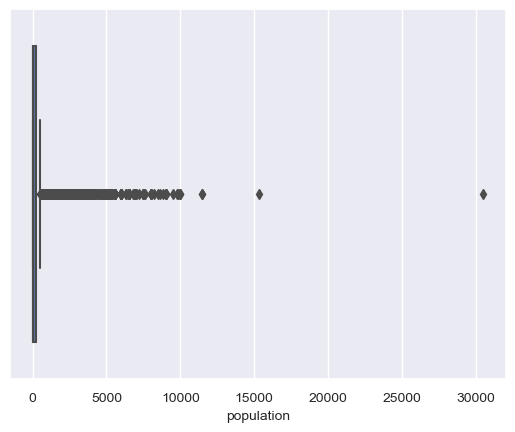

In [97]:
sns.boxplot(x=data.population)
plt.show()

## 1.4. Preprocesing data

En este punto ya tenemos los datos limpios, vamos a convertir las variables categóricas a numéricas y para ello usaremos label enconder, ase aplica label encoder a todo el dataset excepto a la variable objetivo, para mantener así sus valores NA que definen los registros de los datos de test. Como paso previo a aplicar label encoder, serán separar entre variables numéricas y categóricas.

### 1.4.1. label encoder

In [98]:
# Seleccionamos variables numericas/categóricas, actualizando los valores de cat_cols y num_cols

cat_cols = data.select_dtypes(include=['object','category']).columns
num_cols = data.select_dtypes(exclude=['object','category']).columns

In [99]:
# Bucle que recorre todas las variables categóricas y las convierte a numéricas aplicando label encoder
# Se pone la condicion de que si la variables es status_group, es decir la variable objetivo, 
# no hacemos nada, asi conseguimos no convertir esa variable a numérica.
for var in data[cat_cols].columns:

    # Si es la variable objetivo
    if var == 'status_group':
        pass
        # Si no es la variable objetivo, aplicamos label encoder
    else:
        # Convertir valores booleanos a cadenas de texto para que no de error el bucle al aplicar label encoder.
        data[var] = data[var].astype(str)
        le = LabelEncoder()
        le.fit(data[var].unique())
        transformed_values = le.transform(data[var])  # Transforma los valores
        data[var] = transformed_values  # Asigna los valores transformados de nuevo a la columna

### 1.4.2. Conversion de variable objetivo a numérica

##### Ahora de forma individual, voy a transformar los valores de la variable objetivo status_group del dataset que usaremos para entrenar 'data'. Haremos las siguientes transformaciones:
- ****functional = 1****
- ****non functional = 2****
- ****functional needs repair = 3****

In [100]:
data.status_group.replace(('functional','non functional','functional needs repair'),
                      (1,2,3),inplace=True)

#Compruebo los valores de status_group
print(data.status_group.value_counts())

status_group
1.0    32259
2.0    22824
3.0     4317
Name: count, dtype: int64


### 1.4.3. Correlación y relación entre variables.

Ademas de ver que variables tienen mayor correlación respecto a la variable objetivo, se va mostrar la matriz de correlación entre todas las variables para ver cuales tienen correlación entre ellas.
Vamos a ver la correlación de status_group con las demás variables para tener una guía previa del dataset.

In [101]:
corr = abs(data.corr())
corr[['status_group']].sort_values(by = 'status_group',ascending = False).style.background_gradient()

,status_group
status_group,1.000000
waterpoint_type,0.127764
waterpoint_type_group,0.124691
gps_height,0.096408
quality_group,0.087941
region_code,0.083590
extraction_type_class,0.078307
payment,0.075932
region,0.063915
construction_year,0.056893


#### 1.4.4. Matriz de Correlación

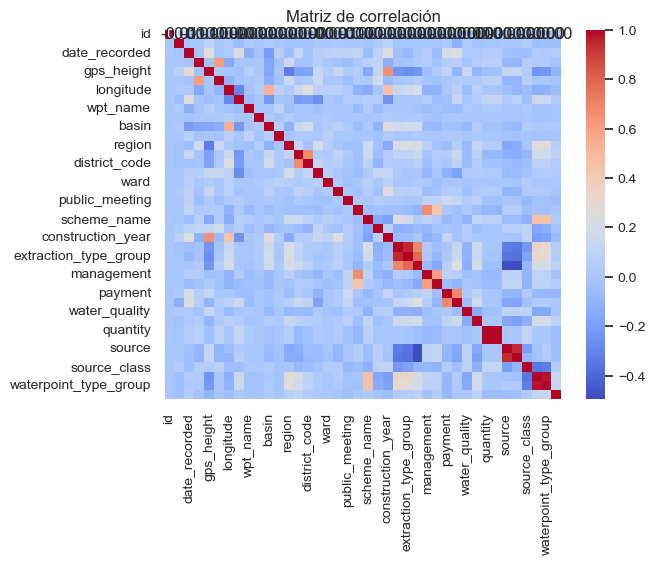

Listado de las 20 primeras correlaciones ordenadas:
quantity_group - quantity: 1.00
quantity - quantity_group: 1.00
waterpoint_type - waterpoint_type_group: 0.98
waterpoint_type_group - waterpoint_type: 0.98
extraction_type - extraction_type_group: 0.95
extraction_type_group - extraction_type: 0.95
source - source_type: 0.94
source_type - source: 0.94
extraction_type_class - extraction_type_group: 0.78
extraction_type_group - extraction_type_class: 0.78
extraction_type - extraction_type_class: 0.69
extraction_type_class - extraction_type: 0.69
payment - payment_type: 0.69
payment_type - payment: 0.69
region_code - district_code: 0.68
district_code - region_code: 0.68
scheme_management - management: 0.67
management - scheme_management: 0.67
gps_height - construction_year: 0.66
construction_year - gps_height: 0.66


In [102]:
visualizar_correlaciones(data)

Vemos una correlación muy alta entre bastantes variables. Una correlación cercana a 1 indica una relacion lineal muy fuerte entre ellas, implicando que los cambios en una variable están relacionados con cambios en la otra variable. 

Se van a seleccionar aquellas variables que tienen más de un 50% de correlación entre ellas y analizarlas:

#### 1.4.5. Variables correlacionadas

En este punto se aborda la correlación entre variables.

Teoricamente a la hora de seleccionar las variabels que van a definir el modelo, no es bueno integrar variables con correlacion entre ellas, que una variable tenga una correlacion alta (hasta 1 maximo) con otra variable no objetivo, implica que se comporta de forma similar, o lo que es lo mismo, visto desde la variable objetivo, esas 2 variables son la misma, por lo tanto no aportan nada diferente al modelo, además de . Esto, además de implicar más datos a la hroa de procesar información. LAS variables independientes, deben ser independientes ... en el momento que dejan de serlo, hacen que el modelo tenga problemas de multicolinealidad.

*****A pesar de lo que dice la teoría, encuentro que el modelo se comporta peor si le quito variables, aunque estas presenten una correlación de 1, o muy cercana a 1*****
****Se deja toda la parte de correlación en formato RAW al no aportar nada al modelo en cuanto a scoring****
****La conclusión es que la eliminación de variables con correlación, no han mejorado el modelo inicial.****

#### correlacion1 - quantity - quantity_group: 1.00

#### correlacion2 - waterpoint_type - waterpoint_type_group: 0.98

La correlacion de 0.98 nos indica que estamos ante la misma variable con algunas excepciones, pero solo en el 2% de los casos.
Se procede a eliminar la variable waterpoint_type_group del dataset

La variable waterpoint_type, además de la categoría communal standpipe, presenta la categoría communal standpipe multiple, salvo pro esa diferencia, estamos ante la misma variable, además por la definición de las 2 categorías deducimos que podríamos aunarlasw como communal standpipe.
Debido a esto y la alta correlación entre ellas, casi de 1. vamos a borrar la variable waterpoint_type_group del dataset.

#### correlación3 - extraction_type - extraction_type_group: 0.95

Examinando ambas variables, viendo la correlacion entre sus categorías, podemos deducir que nos encontramos casi ante la misma variable de forma duplicada, no aporta mucha informació nadicional al modelo.
Se procede a borrar extraction_type del dataset

#### correlación4 - source - source_type: 0.94

Como se encuentra una relatividad casi del 100% de los valores, source y source_type actuan casi como la misma variable.
Se procede a borrar la variable source_type del dataset

#### correlacion5 - extraction_type - extraction_type_class: 0.78

Por la naturaleza de sus variables, se denota bastante equivalencia entre sus categorias, borramos extraction_type_class

#### correlacion6 - payment_type - payment: 0.69

 Aunque con otra denominacion, payment type y payment son la misma variable.
 Nos quedamos con payment_type

#### 1.4.6.  Separación dataset de training/test y dataset para predecir (X_pred)

Una vez se han tratado ya los datos, vamos a separar el dataset que usaremos para training/test: data_train, y el dataset que usaremos para predecir: data_pred .


In [103]:
#Guardamos en data_pred, el dataset que usaremos para predecir
data_pred = data.loc[data['id'].isin(ids_test_values)]
data_pred = data_pred.drop(columns=['status_group'])

# Resetear el índice del DataFrame resultante
data_pred.reset_index(drop=True, inplace=True)

# Una vez se han tratado ya los datos, vamos a separar el dataset que usaremos para training/test: data_train, 
#y el dataset que usaremos para predecir: data_pred.

data_train = data.drop(data[data['id'].isin(ids_test_values)].index)
data_train.reset_index(drop=True, inplace=True)

In [104]:
data_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  int32  
 3   funder                 14850 non-null  int32  
 4   gps_height             14850 non-null  int64  
 5   installer              14850 non-null  int32  
 6   longitude              14850 non-null  int32  
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  int32  
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  int32  
 11  subvillage             14850 non-null  int32  
 12  region                 14850 non-null  int32  
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [105]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  int32  
 3   funder                 59400 non-null  int32  
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  int32  
 6   longitude              59400 non-null  int32  
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  int32  
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  int32  
 11  subvillage             59400 non-null  int32  
 12  region                 59400 non-null  int32  
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

# 2 - MODELING

En este apartado, nos centramos en probar los diferentes ajustes del modelo, una vez lo configuramos correctamente, pasamos al proceso de entrenamiento y a evaluar el modelo o los diferentes modelos.
Es un enfoque interesante probar diferentes modelos, es decir establecer un ciclo de creación y entrenamiento de modelos de forma que podamos comparar diferentes ajustes y configuraciones.

##  2.1. Balanceo de datos con datos sintéticos: Oversampling/Undersampling
Al examinar los datos de la variable objetivo, se puede comprobar que el grupo 3 es bastante minoritatio. Decido aplicar la técnica de oversampling para balancear un poco los pesos de los grupos, creando datos sintéticos. 

Para aplicar oversampling, y generar datos sintéticos, vamos a filtrar el dataset para aquellos registros cuyo valor de status_group sea de 2 y de 3. Nos interesa rebalancear los datos con status_group = 3, y vamos a tomar el valor 2 como referencia. Con este proceso, aumentamos la información con datos sintéticas, aumentando los registros con variable objetivo = 3.

### 2.2. Model Training

Proceso de muestreo, creación y entrenamiento de los modelos. Muestreo estratificado en función de la variable objetivo, para que en los splits sus categorías estén bien representadas. Importante tener en cuenta que nos encontramos en un problema de modelo supervisado.

En el intento de balanceo de datos, la generación de datos sintéticos no ha sido interesante, según los resultados obtenidos se han empeorado los datos. Se harán diferentes splits para generar diferentes balanceos como técnica para balandear los datos. 
Se van a hacer splits de 10/90 15/85 20/80 25/75 30/70, generando varios modelos que podremos comporar.

Para validar nuestro modelo, podemos usar cualquiera de las siguientes métricas: accuracy, precission, recall, o f1(diferencia entre decission y recall). Una vez se crea el modelo y lo entrenamos, ya podremos realizar una predicción usando los registros de test que nos dan como x_pred, obteniendo la y_pred.

Para entrenar el modelo usaremos la data de entrenamiento , que denominamos 'data_train'
Para predecir usaremos la data para test, que denominamos 'data_pred'

Se van a generar diferentes modelos que compararemos de forma básica para decidirnos por uno:
- Decision Tree
- Random Forest
- Super Vector Machine
- Regresión Logística

#### 2.2.1. Split data training/test

Genero el conjunto de datos con diferentes % en el split. Diferentes combinaciones en el split de training/test puede darnos modelos más eficientes, por ello vamos a crear 4 conjuntos de datos para training/ test abarcando los diferentes porcentajes del split.


In [106]:
#Split 85/15
X_train_15, X_test_15, y_train_15, y_test_15 = split_data(data_train, test_size=0.15)

#Split 80/20
X_train_20, X_test_20, y_train_20, y_test_20 = split_data(data_train, test_size=0.20)

#Split 75/25
X_train_25, X_test_25, y_train_25, y_test_25 = split_data(data_train, test_size=0.25)

#Split 70/30
X_train_30, X_test_30, y_train_30, y_test_30 = split_data(data_train, test_size=0.30)

In [107]:
#Split 80/20 default
X_train, X_test, y_train, y_test = split_data(data_train, test_size=0.20)

#### 2.2.2. Creación del modelo

En este punto, vamos a comparar 4 modelos básicos para decidirnos cual va a ser el que decidamos para resolver el problema supervisado.
***<p>El modelo más eficiente ha resultado ser un Random Forest, por lo que se mantendrá el código de los demás modelos en formato RAW***

#### - 1er Método - Decision Tree (RAW)

#### - 2o Método - Random Forest (Modelo final)

In [108]:
# Modelo y predicciones:
# Instanciamos un modelo, este caso un arbol de decision. Y entrenamos con el parametro de gini.
model_rf = RandomForestClassifier().fit(X_train_20, y_train_20)
#Hacemos la predicción
y_pred_rf = model_rf.predict(X_test_20)


print(classification_report(y_test_20, y_pred_rf))


              precision    recall  f1-score   support

         1.0       0.80      0.90      0.85      6452
         2.0       0.85      0.77      0.81      4565
         3.0       0.59      0.35      0.44       863

    accuracy                           0.81     11880
   macro avg       0.75      0.67      0.70     11880
weighted avg       0.81      0.81      0.81     11880



#### - 3er Método -  Super Vector Machine (RAW)

#### - 4o Método - Logistic Regression (RAW)

## 2.3. Feature Engineering

En esta sección buscaremos mejorar el modelo con diferentes configuraciones y ajustes de los hiper-parámetros.

#### 2.3.1. Featuring Engineering3 - XGBOOST (RAW)

Al no mejorar el modelo, descartamos aplicar XGBOOST, dejandolo en RAW

#### 2.3.2. Featuring Engineering2 - Tunning de hiper-parámetros con GridSearchCV (RAW)

Para encontrar cuales son los mejores hyperparámetros para nuestro RandomForest, 
vamos a crear un diccionario que definiremos como grid_param, lo usaremos para usar la técnica de 'grid search' donde vamos a intentar encontrar la mejor combinacion posible.
En este proyecto, tenemos una variable objetivo multivariante, toma 3 posibles valores, por lo que al no ser bivariable no podemos usar el area de la curva ROC como medida para valorar cada configuración, en su lugar indicamos que el scoring será accuracy.

Como vimos previamente, intentamos balancear la distribución de los datos en cuanto a valores de la variable objetivo.
El grupo de los valores = 3 esta muy desbalanceado, hay muy poca proporcion respecto a los demás valores.
Para balancearlo en un primer momento usamos la técnica de oversampling, generando datos sintéticos en diferentes proporciones 20%,30%,40%, incluso 100%. El proceso se realizo tomando a  status_group = 2 como valor referencia, pero no resultó ser efectivo, los scores de los modelos bajaban.

Haciendo uso de tunning de hiper-parámetros vamos a intentar hacer uso de la propiedad ***'class-weight'***. Con esta propiedad conseguimos dar distintos pesos a las distintas categorías de la variable group_status. Como nos interesa balancear el peso de status_group = 3, probamos configuraciones potenciando esta categoria: {1: 1, 2: 1, 3: 2}, {1: 1, 2: 1, 3: 3}, duplicando y triplicando su peso.

****Importante señalar que se ha configurado el scoring con roc_auc_ovr. Al encontrarnos con una variable objetivo multivariante, no podemos usar el area de la curva ROC ya que necesita una variable dicotómica, en su lugar usamos la estrategia  uno contra el resto (One-Versus-Rest, OvR) que es correcta para problemas de clasificación multiclase.****

****Como estamos explorando diferentes % de split a la hroa de dividir el dataset en training/test, , se debe pasar por el GridSearchCV con ese modelo. Cuando ejecutamos el model_grid.fit(X_train, y_train), tenemos que indicar en cada caso el modelo, el X_train y el y_train que vamos a usar después para que nos dé los hiperparámetros más optimos para cada caso. De lo contrario, la configuración de hiperparámetros optima es solo relativa a ese split****

****Es decir, debemos probar el modelo con los diferentes splits para averiguar cual es la configuración optima para cada uno de ellos****

****Los resultados obtenidos como mejores hiperparámetros son los siguientes:****

****Mejores parámetros encontrados para la iteración 3 con 20/80 de split. (scoring: roc_auc_ovr):
{'class_weight': {1: 1, 2: 1, 3: 2}, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
Precisión media del mejor modelo encontrado: 0.9048618858949835****


Una vez que tenemos la configuracion de hiper-parámetros optima creamos un modelo por cada split que hemos realizado con diferete porcentaje, 85/15, 80/20, 75/25, 70/30. Ahora vamos a generar 3 modelos de forma que cada uno de ellos sea entrenado con diferente % de split.

In [ ]:
model_rf_15 = RandomForestClassifier(class_weight={1: 1, 2: 1, 3: 2}, criterion='entropy', max_depth=20, max_features='auto', n_estimators=500).fit(X_train_15, y_train_15)
model_rf_20 = RandomForestClassifier(class_weight={1: 1, 2: 1, 3: 2}, criterion='entropy', max_depth=20, max_features='auto', n_estimators=500).fit(X_train_20, y_train_20)
model_rf_25 = RandomForestClassifier(class_weight={1: 1, 2: 1, 3: 2}, criterion='entropy', max_depth=20, max_features='auto', n_estimators=500).fit(X_train_25, y_train_25)

## 2.4. Model Evaluation

Usamos el método de validación cruzada para seleccionar el mejor modelo de todos los generados. Además de un valor medio alto, nos interesa que el model resultante tenga una varianza lo más baja posible.

#### 2.4.1. Uso de validacion cruzada

In [ ]:
list_models = [model_rf_20]
list_X_train = [X_train_20]
list_y_train = [y_train_20]

In [ ]:
# Lista para almacenar los resultados de la validación cruzada
results = {}

# Variables para almacenar el mejor modelo y su promedio
mejor_modelo = None
mejor_promedio = 0

# Recorre la lista de modelos
for i, model in enumerate(list_models, start=1):
   
    # Obtiene el nombre de la variable usando globals()
    model_name = [name for name, value in globals().items() if value is model][0]
    print(f'Iteración {i}: {model_name}')
    
    # Realiza validación cruzada sobre el modelo actual
    scores = cross_val_score(model, list_X_train[i-1], list_y_train[i-1], cv=5)
    
    # Guarda los puntajes de validación cruzada en los resultados
    results[model_name] = scores
    
    # Calcula el promedio de los puntajes
    promedio = scores.mean()
    
    # Imprime los puntajes de validación cruzada para el modelo actual
    print(f"Puntajes de validación cruzada para {model_name}:", scores)
    print("Promedio de puntajes:", promedio)
    print("Desviación estándar de los puntajes:", np.std(scores))
    print("\n")
    
    # Actualiza el mejor modelo si el promedio actual es mayor
    if promedio > mejor_promedio:
        mejor_modelo = model_name
        mejor_promedio = promedio

# Imprime los resultados globales
print("Resultados globales:")
for model_name, scores in results.items():
    print(f"Modelo: {model_name}, Promedio: {scores.mean()}, Desviación estándar: {np.std(scores)}")

# Imprime el mejor modelo
print(f"El mejor modelo es: {mejor_modelo}, con un promedio de puntajes de: {mejor_promedio}\n")

Una vez obtenido el mejor modelo, ya podemos hacer la predicción y exportar a CSV con el formato que se nos indica.

In [ ]:
#Guardamos el modelo más eficiente como model_final
model_final = model_rf_20

In [ ]:
#Realizamos la predicción con los data_pred, que usamos como x_pred, dando lugar a la y_pred
#y_pred = model_final.predict(data_pred.drop(columns=['status_group'], inplace=True))

y_pred = model_final.predict(data_pred)

In [ ]:
#creamos el dataFrame con solo con las ids y su status_group correspondiente
df_pred = pd.DataFrame({'id': data_eval['id'], 'status_group': y_pred})

In [ ]:
#Revertimos la asignación numérica de los valores de status_group
df_pred['status_group'].replace((1, 2, 3), 
                             ('functional', 'non functional', 'functional needs repair'), 
                             inplace=True)

In [ ]:
df_pred.head(10)

In [ ]:
#Convertimos a CSV la predicción y exportamos
df_pred.to_csv('predicciones_final_David_Jesus_Peña_Muñoz.csv', index=False)

En este código, cada modelo se evalúa utilizando la validación cruzada con 5 particiones (5-fold cross-validation). Durante la validación cruzada, se ajusta el modelo en 4 de las particiones y se evalúa en la partición restante. Este proceso se repite 5 veces, de manera que cada partición se utiliza una vez como conjunto de prueba.

Para valorar cada modelo, se utiliza la métrica de precisión (accuracy). La precisión es una métrica comúnmente utilizada para evaluar modelos de clasificación y representa la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones realizadas